# Import libraries

In [2]:
#%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

## Setting max displayed rows to 500, in order to display the full output of any command
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Setting to avoid scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# pour que les valeurs infinies soient considérées aussi comme des NaN :
pd.options.mode.use_inf_as_na = True



import sqlalchemy


# sklearn
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/pandas/compat/__init__.py:109: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# pipelines
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
# preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
# feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
# models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
# model selection
from sklearn.model_selection import RandomizedSearchCV
# scores
from sklearn.model_selection import cross_val_predict, cross_val_score

# Préparation du dataset

In [4]:
import datetime
def calcul_ratios(df):
    df["Credit client"] = (df['Clients et comptes rattachés (3) (net) (BXNET) 2018 (€)']*365)/(df["Chiffre d'affaires net (Total) (FL) 2018 (€)"]*1.2)

    df["Credit Fournisseurs"] = df['Dettes fournisseurs et comptes rattachés (DX) 2018 (€)']*365/(
        (df['Achats de marchandises (y compris droits de douane) (FS) 2018 (€)'] 
        + df['Achats de matières premières et autres approvisionnements (y compris droits de douane) (FU) 2018 (€)'] 
        + df['Autres achats et charges externes (3) (6 bis) (FW) 2018 (€)']
        )*1.2)

    df["Rotation_stocks"] = ( df['Matières premières, approvisionnements (net) (BLNET) 2018 (€)'] + 
             + df['En cours de production de biens (net) (BNNET) 2018 (€)'] 
             + df['En cours de production de services (net) (BPNET) 2018 (€)']
             + df['Produits intermédiaires et finis (net) (BRNET) 2018 (€)']
             + df['Marchandises (net) (BTNET) 2018 (€)'])*365 / (
                df["Chiffre d'affaires net (Total) (FL) 2018 (€)"]  
                - df["1 - RESULTAT D'EXPLOITATION (I - II) (GG) 2018 (€)"])

    df["BFR"] = (
        df['TOTAL (III) (net) (CJNET) 2018 (€)']
        + df['Valeurs mobilières de placement (net) (CDNET) 2018 (€)']
        + df['Disponibilités (net) (CFNET) 2018 (€)']
        - df['Avances et acomptes reçus sur commandes en cours (DW) 2018 (€)']
        - df['Dettes fournisseurs et comptes rattachés (DX) 2018 (€)']
        - df['Dettes fiscales et sociales (DY) 2018 (€)']
        - df['Dettes sur immobilisations et comptes rattachés (DZ) 2018 (€)']
        - df['Autres dettes (EA) 2018 (€)']
        - df["Produits constatés d'avance (EB) 2018 (€)"])


    df["BFRE"] = (
                df['Matières premières, approvisionnements (net) (BLNET) 2018 (€)']
                 + df['En cours de production de services (net) (BPNET) 2018 (€)']
                 + df['En cours de production de biens (net) (BNNET) 2018 (€)']
                 + df['Produits intermédiaires et finis (net) (BRNET) 2018 (€)']
                 + df['Marchandises (net) (BTNET) 2018 (€)']
                 + df['Avances et acomptes versés sur commandes (net) (BVNET) 2018 (€)']
                 + df['Clients et comptes rattachés (3) (net) (BXNET) 2018 (€)']
                - df['Avances et acomptes reçus sur commandes en cours (DW) 2018 (€)']
                - df['Dettes fournisseurs et comptes rattachés (DX) 2018 (€)']
                - df['Dettes fiscales et sociales (DY) 2018 (€)']
                - df['Autres dettes (EA) 2018 (€)']
                 )

    df["Endettement total"] = (df['Autres emprunts obligataires (DT) 2018 (€)']
                 + df['Emprunts obligataires convertibles (DS) 2018 (€)']
                 + df['Emprunts et dettes auprès des établissements de crédit (5) (DU) 2018 (€)']
                 + df['Emprunts et dettes financières divers (DV) 2018 (€)']
                - df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2018 (€)'])

    df["CAF"] = (df['3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2018 (€)']
                - df['Reprises sur amortissements et provisions, transferts de charges (9) (FP) 2018 (€)']
                + df["Dotations d'exploitation sur immobilisations (dotations aux amortissements) (GA) 2018 (€)"]
                + df["Dotations d'exploitation sur immobilisations (dotations aux provisions) (GB) 2018 (€)"]
                + df["Dotations d'exploitation sur actif circulant (dotations aux provisions) (GC) 2018 (€)"]
                + df["Dotations d'exploitation pour risques et charges (dotations aux provisions) (GD) 2018 (€)"]
                - df['Reprises sur provisions & transferts de charges (GM) 2018 (€)']
                + df['Dotations financières aux amortissements et provisions (GQ) 2018 (€)']
                - df["Participation des salariés aux résultats de l'entreprise (HJ) 2018 (€)"]
                - df['Impôts sur les bénéfices (HK) 2018 (€)'])

    df["Capacite de remboursement"] = df["Endettement total"] / df["CAF"]


    df["Ressources durables"] = (df['TOTAL (I) (DL) 2018 (€)']
                 + df['TOTAL(II) (DO) 2018 (€)']
                 + df['TOTAL (III) (DR) 2018 (€)']
                 + df['Autres emprunts obligataires (DT) 2018 (€)']
                 + df['Emprunts obligataires convertibles (DS) 2018 (€)']
                 + df['Emprunts et dettes auprès des établissements de crédit (5) (DU) 2018 (€)']
                 + df['Emprunts et dettes financières divers (DV) 2018 (€)']
                 - df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2018 (€)']
                 - df['Capital souscrit non appelé (I) (AA) 2018 (€)'])


    df["FRNG"] = (df["Ressources durables"]   
                 + df['Ecarts de conversion passif (V) (ED) 2018 (€)']
                 - df['Primes de remboursement des obligations (CM) 2018 (€)']
                 - df['Ecarts de conversion actif (CN) 2018 (€)']
                 + df['TOTAL (II) (net) (BJNET) 2018 (€)'])

    df["Taux endettement"] = df["Endettement total"] / df["Ressources durables"]

    df["Rentabilite financiere"] = (df["RESULTAT DE L'EXERCICE (bénéfice ou perte) (DI) 2018 (€)"] 
                                    / (df['TOTAL (I) (DL) 2018 (€)'] 
                                       - df['Capital souscrit non appelé (I) (AA) 2018 (€)']))

    df["EBE"] = (df["Chiffre d'affaires net (Total) (FL) 2018 (€)"]
                + df["Subventions d'exploitation (FO) 2018 (€)"]
                + df['Production stockée (FM) 2018 (€)']
                + df['Production immobilisée (FN) 2018 (€)']
                - df['Achats de marchandises (y compris droits de douane) (FS) 2018 (€)']
                - df['Variation de stock (marchandises) (FT) 2018 (€)']
                - df['Achats de matières premières et autres approvisionnements (y compris droits de douane) (FU) 2018 (€)']
                - df['Variation de stock (matières premières et approvisionnements) (FV) 2018 (€)']
                - df['Autres achats et charges externes (3) (6 bis) (FW) 2018 (€)']
                - df['Impôts, taxes et versements assimilés (FX) 2018 (€)']
                - df['Salaires et traitements (FY) 2018 (€)']
                - df['Charges sociales (10) (FZ) 2018 (€)']
                + df['(3)\xa0Dont Crédit-bail mobilier (HP) 2018 (€)']
                + df['(3)\xa0Dont Crédit-bail immobilier (HQ) 2018 (€)']
                )

    df["VA"] = (df["EBE"] 
                - df["Subventions d'exploitation (FO) 2018 (€)"]
                + df['Impôts, taxes et versements assimilés (FX) 2018 (€)']
                + df['Salaires et traitements (FY) 2018 (€)']
                + df['Charges sociales (10) (FZ) 2018 (€)'])

    df["Liquidite generale"] = ((df['TOTAL (III) (net) (CJNET) 2018 (€)']
                               - df["Charges constatées d'avance (3) (net) (CHNET) 2018 (€)"])
                               / (df['Avances et acomptes reçus sur commandes en cours (DW) 2018 (€)']
                                 + df['Dettes fournisseurs et comptes rattachés (DX) 2018 (€)']
                                 + df['Dettes fiscales et sociales (DY) 2018 (€)']
                                 + df['Dettes sur immobilisations et comptes rattachés (DZ) 2018 (€)']
                                 + df['Autres dettes (EA) 2018 (€)']
                                 + df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2018 (€)']))


    df["Liquidite reduite"] = (
        (
            (df['TOTAL (III) (net) (CJNET) 2018 (€)']
                               - df["Charges constatées d'avance (3) (net) (CHNET) 2018 (€)"]
            )
                               - (
                                   df['Matières premières, approvisionnements (net) (BLNET) 2018 (€)']
                                 + df['En cours de production de services (net) (BPNET) 2018 (€)']
                                 + df['En cours de production de biens (net) (BNNET) 2018 (€)']
                                 + df['Produits intermédiaires et finis (net) (BRNET) 2018 (€)']
                                 + df['Marchandises (net) (BTNET) 2018 (€)']
                                 )
        ) 
                                / (
                                    df['Avances et acomptes reçus sur commandes en cours (DW) 2018 (€)']
                                 + df['Dettes fournisseurs et comptes rattachés (DX) 2018 (€)']
                                 + df['Dettes fiscales et sociales (DY) 2018 (€)']
                                 + df['Dettes sur immobilisations et comptes rattachés (DZ) 2018 (€)']
                                 + df['Autres dettes (EA) 2018 (€)']
                                 + df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2018 (€)']
                                    )
                                )

    df["Taux ressources propres"] = ((df['TOTAL (I) (DL) 2018 (€)'] 
                                     - df['Capital souscrit non appelé (I) (AA) 2018 (€)'])
                                    / df['TOTAL GENERAL (I à V) (EE) 2018 (€)'])

    #df["CA par employe"] = gérer les 0

    df["Rentabilite des capitaux propres"] = (df["RESULTAT DE L'EXERCICE (bénéfice ou perte) (DI) 2018 (€)"]
                                             / (df['TOTAL (I) (DL) 2018 (€)']
                                                + df['TOTAL(II) (DO) 2018 (€)']
                                                - df['Capital souscrit non appelé (I) (AA) 2018 (€)']))

    df["Autonomie financiere"] = ((df['TOTAL (I) (DL) 2018 (€)']
                                                + df['TOTAL(II) (DO) 2018 (€)']
                                                - df['Capital souscrit non appelé (I) (AA) 2018 (€)'])
                                  / df['TOTAL GENERAL (I à V) (EE) 2018 (€)'])

    df["Poids interets"] = (df['Intérêts et charges assimilées (GR) 2018 (€)'] 
                            / df["1 - RESULTAT D'EXPLOITATION (I - II) (GG) 2018 (€)"])

    df["Taux EBE"] = (df["EBE"]
                      / df["Chiffre d'affaires net (Total) (FL) 2018 (€)"])

    df["Taux VA"] = (df["VA"]
                      / df["Chiffre d'affaires net (Total) (FL) 2018 (€)"])

    df["Taux Rentabilite"] = (df["RESULTAT DE L'EXERCICE (bénéfice ou perte) (DI) 2018 (€)"]
                             / df["Chiffre d'affaires net (Total) (FL) 2018 (€)"])

    df["Poids dettes fiscales"] = ((df['Sécurité sociale et autres organismes sociaux - Montant brut (8D) 2018 (€)']
                                   + df['Impôts sur les bénéfices - Montant brut (8E) 2018 (€)']
                                   + df['T.V.A. - Montant brut (VW) 2018 (€)'])
                                   / df["Chiffre d'affaires net (Total) (FL) 2018 (€)"])


    df["Tresorerie"] = df["FRNG"] - df["BFR"]
    
    df["Taux augmentation endettement CT"] = (df['Emprunts souscrits en cours d’exercice - à 1 an au plus (VJ2) 2018 (€)']
                                         / df['TOTAL GENERAL (I à V) (EE) 2018 (€)'])

    
    df["Croissance CA"] = ((df["Chiffre d'affaires net (Total) (FL) 2018 (€)"] 
                       - df["Chiffre d'affaires net (Total) (FL) 2017 (€)"]) 
                        / df["Chiffre d'affaires net (Total) (FL) 2017 (€)"]) 
    
    df["Apport en comptes courants"] = (df["dont comptes courants d'associés de l'exercice N (EA2) 2018 (€)"] 
                       - df["dont comptes courants d'associés de l'exercice N (EA2) 2017 (€)"]) 
                      
    df["Date de création"] = pd.to_datetime(df["Date de création"])
    df["Age entreprise"] = ((datetime.datetime(2019,12,31) - df["Date de création"])/np.timedelta64(1, 'M'))
    df["Age entreprise"] = df["Age entreprise"].astype(int)
    
    return df

In [5]:
def suppr_nulls_nans(df):
    # suppression des entreprises avec CA null
    df = df[df["Chiffre d'affaires net (Total) (FL) 2018 (€)"] > 0]
    # suppression des colonnes avec plus de 12% de NaN (sauf tranche d'effectif)
    cols_null_to_drop = ["Procédures collectives (type)", 
                         "Procédures collectives (date)", 
                         "Croissance CA", 
                         "Apport en comptes courants", 
                         "dont comptes courants d'associés de l'exercice N (EA2) 2017 (€)", 
                         "Chiffre d'affaires net (Total) (FL) 2017 (€)"]
    df = df.drop(cols_null_to_drop, axis=1)
    # passage des valeurs infinies en nan
    df = df.replace([np.inf, -np.inf], np.nan)
    return df

In [6]:
def merge_naf(df, naf_path):
    df_naf = pd.read_excel(naf_path, header=[1])
    df_naf = df_naf.drop(["Unnamed: 10", "Unnamed: 11", "Unnamed: 12", "Unnamed: 13", "Unnamed: 14", "Unnamed: 15",
            "Unnamed: 16", "Unnamed: 17", "Unnamed: 18", "Unnamed: 19", "Unnamed: 20", "Unnamed: 21", "Unnamed: 22"], axis=1)
    df_naf = df_naf.rename(columns={'Unnamed: 1':'Descriptif A 732'})
    # Step 1 - suppression des points dans la colonne A 732
    # pour avoir le même format que dans les données d'entreprises
    for row in range(df_naf.shape[0]):
        df_naf.loc[row,'A 732'] = df_naf.loc[row,'A 732'].replace('.', '')
    # Step 2 - Join avec le dataset d'entreprises 
    # (pour la mise en DB, il faudra créér deux tables et faire les joins dans la requête SQL)
    df_merged = pd.merge(df, df_naf, how = 'left', left_on = df['Code APE'], right_on = df_naf['A 732'])
    df_merged = df_merged.drop(['key_0'], axis=1)
    assert df_merged.shape[0]==df.shape[0]
    assert df_merged.shape[1]==df.shape[1]+df_naf.shape[1]
    return df_merged, df_naf

In [7]:
# no longer used
def effectif_encoder(df):
    dic_effectif = { "0 salarié pendant l'année" : 0
                , "0 salarié à la fin de l'année" : 1
                , "De 1 à 2 salariés" : 2
                , "De 3 à 5 salariés" : 3
                , "De 6 à 9 salariés" : 4
                , "De 10 à 19 salariés" : 5
                , "De 20 à 49 salariés" : 6
                , "De 50 à 99 salariés" : 7
                , "De 100 à 199 salariés" : 8
                , "De 200 à 249 salariés" : 9
                , "De 250 à 499 salariés" : 10
                , "De 500 à 999 salariés" : 11
                , "De 1000 à 1999 salariés" : 12
                , "De 2000 à 4999 salariés" : 13 
    }
    df["Tranche effectifs"] = df["Tranche effectifs"].map(dic_effectif)
    return df

In [8]:
# no longer used
def encode_naf21(df):
    dict_naf21 = {'C':0,
                  'E':1,
                  'P':2,
                  'H':3,
                  'F':4,
                  'I':5,
                  'R':6,
                  'G':7,
                  'N':8,
                  'J':9,
                  'S':10,
                  'Q':11,
                  'M':12,
                  'K':13,
                  'A':14,
                  'L':15,
                  'D':16,
                  'O':17,
                  'B':18
    }
    df["A 21 encoded"] = df["A 21"].map(dict_naf21)
    return df

In [9]:
def remove_useless_cols(df):
    useless_cols = [
        "Dénomination",
        "Tranche effectifs",
        "Code APE",
        "Ville",
        "Emprunts remboursés en cours d’exercice (VK) 2018 (€)",
        "Descriptif A 732",
        "A 732",
        "A 615",
        "A 272",
        "A 129",
        "A 88",
        "A 64",
        "A 38",
        "A 10",
        "SIREN",
        "SIRET",
        "Code postal",
        "Emprunts souscrits en cours d’exercice - à 1 an au plus (VJ2) 2018 (€)",
        "Emprunts souscrits en cours d’exercice - à plus d'un an et 5 ans au plus (VJ3) 2018 (€)",
        "Emprunts souscrits en cours d’exercice - à plus de 5 ans (VJ4) 2018 (€)"
    ]
    
    df = df.drop(useless_cols, axis=1)
    return df

In [10]:
def count_outliers(df, col):
    mean = np.mean(df[col], axis=0)
    sd = np.std(df[col], axis=0)
    minimum = mean - 20 * sd
    maximum = mean + 20 * sd
    df_outliers = df.loc[(df[col] <= minimum) | (df[col] >= maximum)]
    return df_outliers.shape[0]

def remove_outliers(df, col):
    mean = np.mean(df[col], axis=0)
    sd = np.std(df[col], axis=0)
    minimum = mean - 20 * sd
    maximum = mean + 20 * sd
    df = df.loc[(df[col] > minimum) & (df[col] < maximum)]
    return df

In [11]:
def apply_categorical_dtypes(df):
    df = df.astype({"Catégorie juridique (Niveau II)" : 'category', 
                            'A 21' : 'category'})
    return df

In [14]:
def get_prepared_df():
    df = pd.read_csv("../data/data_used/total_2018.csv", sep=",")
    print("shape d'origine ----> ", df.shape)
    df = calcul_ratios(df)
    df = suppr_nulls_nans(df)
    print("après suppr des nulls/nan ----> ", df.shape)
    df, df_naf = merge_naf(df, naf_path="../data/data_used/table_NAF2-NA.xls")
    df = remove_useless_cols(df)
    df = apply_categorical_dtypes(df)
    for col in df.select_dtypes(np.number):
        df = remove_outliers(df, col)
    print("après suppr des outliers ----> ", df.shape)
    return df

In [15]:
df = get_prepared_df()

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (87) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


shape d'origine ---->  (8784, 103)
après suppr des nulls/nan ---->  (6188, 126)
après suppr des outliers ---->  (5740, 116)


# Préparation de la modélisation
## Train test split

In [13]:
#### Train test split

from sklearn.model_selection import train_test_split

# on peut dans un premier temps séparer en 2 le dataset :
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

# on vérifie que la distribution de la target reste OK dans les test et train set => c'est OK
trainset['default'].value_counts(normalize=True)

testset['default'].value_counts(normalize=True)




0.00000   0.61847
1.00000   0.38153
Name: default, dtype: float64

## Fonction d'évaluation des modèles

In [14]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
# la learning curve est indispensable pour identifier l'over ou l'under fitting
# inspirée de machine_lerania
from sklearn.model_selection import learning_curve

def evaluate(model, X_train, y_train, X_test, y_test):
    
    # on entraine le modèle
    model.fit(X_train, y_train)
    # on fait les predictions
    y_pred = model.predict(X_test)
    
    # on fait la confusion_matrix
    conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
    conf = conf.rename(columns={0: 'Predicted 0',1:'Predicted 1'})
    conf = conf.rename(index={0: 'Actual 0',1:"Actual 1"})
    conf["TOTAL"] = conf["Predicted 0"]+conf["Predicted 1"]
    conf = conf.append(pd.Series(conf.sum(axis=0), name="TOTAL"))

    
    print("__---__ CONFUSION MATRIX __---__")
    print(conf)
    print("\n__---__ CLASSIFICATION REPORT __---__")
    print(classification_report(y_test, y_pred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    # on visualise ca dans un graphique
    plt.figure(figsize=(12, 8))
    # évolu du train_score en fonction du nombre d'échantillons (N)
    # on prend le score_mean car on est en cross-val
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

# Exemple d'usage :    
#X1_train = trainset[["A 21 encoded"]]
#y1_train = trainset["default"]
#X1_test = testset[["A 21 encoded"]]
#y1_test = testset["default"]
# model = LogisticRegression()

#evaluate(model)    

In [15]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
# la learning curve est indispensable pour identifier l'over ou l'under fitting
# inspirée de machine_lerania
from sklearn.model_selection import learning_curve

def evaluate2(model, X_train, y_train, X_test, y_test):
    
    # on entraine le modèle
    model.fit(X_train, y_train)
    # on fait les predictions
    y_pred = model.predict(X_test)
    
    # on fait la confusion_matrix
    conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
    conf = conf.rename(columns={0: 'Predicted 0',1:'Predicted 1'})
    conf = conf.rename(index={0: 'Actual 0',1:"Actual 1"})
    conf["TOTAL"] = conf["Predicted 0"]+conf["Predicted 1"]
    conf = conf.append(pd.Series(conf.sum(axis=0), name="TOTAL"))

    
    print("__---__ CONFUSION MATRIX __---__")
    print(conf)
    print("\n__---__ CLASSIFICATION REPORT __---__")
    print(classification_report(y_test, y_pred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    # on visualise ca dans un graphique
    plt.figure(figsize=(12, 8))
    # évolu du train_score en fonction du nombre d'échantillons (N)
    # on prend le score_mean car on est en cross-val
    plt.plot(N, (1-train_score.mean(axis=1)), label='train error')
    plt.plot(N, (1-val_score.mean(axis=1)), label='validation error')
    plt.legend()
    # Add title and axis names
    plt.title('LEARNING CURVES')
    plt.xlabel('sample size')
    plt.ylabel('error (1 - F1 score)')

# Exemple d'usage :    
#X1_train = trainset[["A 21 encoded"]]
#y1_train = trainset["default"]
#X1_test = testset[["A 21 encoded"]]
#y1_test = testset["default"]
# model = LogisticRegression()

#evaluate(model)   

# Récupération des données et premier enrichissement (calcul des ratios)


## Récupération des données

In [10]:
df = pd.read_csv("../data/total_2018.csv")

In [11]:
df.shape

(8784, 103)

In [12]:
print(df.columns.to_list())

['SIREN', 'Dénomination', 'SIRET', 'Code APE', 'Procédures collectives (type)', 'Procédures collectives (date)', 'Code postal', 'Date de création', 'Tranche effectifs', 'Capital souscrit non appelé (I) (AA) 2018 (€)', 'TOTAL (II) (net) (BJNET) 2018 (€)', 'Matières premières, approvisionnements (net) (BLNET) 2018 (€)', 'En cours de production de biens (net) (BNNET) 2018 (€)', 'En cours de production de services (net) (BPNET) 2018 (€)', 'Produits intermédiaires et finis (net) (BRNET) 2018 (€)', 'Marchandises (net) (BTNET) 2018 (€)', 'Avances et acomptes versés sur commandes (net) (BVNET) 2018 (€)', 'Clients et comptes rattachés (3) (net) (BXNET) 2018 (€)', 'Autres créances (3) (net) (BZNET) 2018 (€)', 'Capital souscrit et appelé, non versé (net) (CBNET) 2018 (€)', 'Valeurs mobilières de placement (net) (CDNET) 2018 (€)', 'Disponibilités (net) (CFNET) 2018 (€)', "Charges constatées d'avance (3) (net) (CHNET) 2018 (€)", 'TOTAL (III) (net) (CJNET) 2018 (€)', 'Primes de remboursement des obl

## Calul des ratios

In [13]:
def calcul_ratios(df):
    df["Credit client"] = (df['Clients et comptes rattachés (3) (net) (BXNET) 2018 (€)']*365)/(df["Chiffre d'affaires net (Total) (FL) 2018 (€)"]*1.2)

    df["Credit Fournisseurs"] = df['Dettes fournisseurs et comptes rattachés (DX) 2018 (€)']*365/(
        (df['Achats de marchandises (y compris droits de douane) (FS) 2018 (€)'] 
        + df['Achats de matières premières et autres approvisionnements (y compris droits de douane) (FU) 2018 (€)'] 
        + df['Autres achats et charges externes (3) (6 bis) (FW) 2018 (€)']
        )*1.2)

    df["Rotation_stocks"] = ( df['Matières premières, approvisionnements (net) (BLNET) 2018 (€)'] + 
             + df['En cours de production de biens (net) (BNNET) 2018 (€)'] 
             + df['En cours de production de services (net) (BPNET) 2018 (€)']
             + df['Produits intermédiaires et finis (net) (BRNET) 2018 (€)']
             + df['Marchandises (net) (BTNET) 2018 (€)'])*365 / (
                df["Chiffre d'affaires net (Total) (FL) 2018 (€)"]  
                - df["1 - RESULTAT D'EXPLOITATION (I - II) (GG) 2018 (€)"])

    df["BFR"] = (
        df['TOTAL (III) (net) (CJNET) 2018 (€)']
        + df['Valeurs mobilières de placement (net) (CDNET) 2018 (€)']
        + df['Disponibilités (net) (CFNET) 2018 (€)']
        - df['Avances et acomptes reçus sur commandes en cours (DW) 2018 (€)']
        - df['Dettes fournisseurs et comptes rattachés (DX) 2018 (€)']
        - df['Dettes fiscales et sociales (DY) 2018 (€)']
        - df['Dettes sur immobilisations et comptes rattachés (DZ) 2018 (€)']
        - df['Autres dettes (EA) 2018 (€)']
        - df["Produits constatés d'avance (EB) 2018 (€)"])


    df["BFRE"] = (
                df['Matières premières, approvisionnements (net) (BLNET) 2018 (€)']
                 + df['En cours de production de services (net) (BPNET) 2018 (€)']
                 + df['En cours de production de biens (net) (BNNET) 2018 (€)']
                 + df['Produits intermédiaires et finis (net) (BRNET) 2018 (€)']
                 + df['Marchandises (net) (BTNET) 2018 (€)']
                 + df['Avances et acomptes versés sur commandes (net) (BVNET) 2018 (€)']
                 + df['Clients et comptes rattachés (3) (net) (BXNET) 2018 (€)']
                - df['Avances et acomptes reçus sur commandes en cours (DW) 2018 (€)']
                - df['Dettes fournisseurs et comptes rattachés (DX) 2018 (€)']
                - df['Dettes fiscales et sociales (DY) 2018 (€)']
                - df['Autres dettes (EA) 2018 (€)']
                 )

    df["Endettement total"] = (df['Autres emprunts obligataires (DT) 2018 (€)']
                 + df['Emprunts obligataires convertibles (DS) 2018 (€)']
                 + df['Emprunts et dettes auprès des établissements de crédit (5) (DU) 2018 (€)']
                 + df['Emprunts et dettes financières divers (DV) 2018 (€)']
                - df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2018 (€)'])

    df["CAF"] = (df['3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2018 (€)']
                - df['Reprises sur amortissements et provisions, transferts de charges (9) (FP) 2018 (€)']
                + df["Dotations d'exploitation sur immobilisations (dotations aux amortissements) (GA) 2018 (€)"]
                + df["Dotations d'exploitation sur immobilisations (dotations aux provisions) (GB) 2018 (€)"]
                + df["Dotations d'exploitation sur actif circulant (dotations aux provisions) (GC) 2018 (€)"]
                + df["Dotations d'exploitation pour risques et charges (dotations aux provisions) (GD) 2018 (€)"]
                - df['Reprises sur provisions & transferts de charges (GM) 2018 (€)']
                + df['Dotations financières aux amortissements et provisions (GQ) 2018 (€)']
                - df["Participation des salariés aux résultats de l'entreprise (HJ) 2018 (€)"]
                - df['Impôts sur les bénéfices (HK) 2018 (€)'])

    df["Capacite de remboursement"] = df["Endettement total"] / df["CAF"]


    df["Ressources durables"] = (df['TOTAL (I) (DL) 2018 (€)']
                 + df['TOTAL(II) (DO) 2018 (€)']
                 + df['TOTAL (III) (DR) 2018 (€)']
                 + df['Autres emprunts obligataires (DT) 2018 (€)']
                 + df['Emprunts obligataires convertibles (DS) 2018 (€)']
                 + df['Emprunts et dettes auprès des établissements de crédit (5) (DU) 2018 (€)']
                 + df['Emprunts et dettes financières divers (DV) 2018 (€)']
                 - df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2018 (€)']
                 - df['Capital souscrit non appelé (I) (AA) 2018 (€)'])


    df["FRNG"] = (df["Ressources durables"]   
                 + df['Ecarts de conversion passif (V) (ED) 2018 (€)']
                 - df['Primes de remboursement des obligations (CM) 2018 (€)']
                 - df['Ecarts de conversion actif (CN) 2018 (€)']
                 + df['TOTAL (II) (net) (BJNET) 2018 (€)'])

    df["Taux endettement"] = df["Endettement total"] / df["Ressources durables"]

    df["Rentabilite financiere"] = (df["RESULTAT DE L'EXERCICE (bénéfice ou perte) (DI) 2018 (€)"] 
                                    / (df['TOTAL (I) (DL) 2018 (€)'] 
                                       - df['Capital souscrit non appelé (I) (AA) 2018 (€)']))

    df["EBE"] = (df["Chiffre d'affaires net (Total) (FL) 2018 (€)"]
                + df["Subventions d'exploitation (FO) 2018 (€)"]
                + df['Production stockée (FM) 2018 (€)']
                + df['Production immobilisée (FN) 2018 (€)']
                - df['Achats de marchandises (y compris droits de douane) (FS) 2018 (€)']
                - df['Variation de stock (marchandises) (FT) 2018 (€)']
                - df['Achats de matières premières et autres approvisionnements (y compris droits de douane) (FU) 2018 (€)']
                - df['Variation de stock (matières premières et approvisionnements) (FV) 2018 (€)']
                - df['Autres achats et charges externes (3) (6 bis) (FW) 2018 (€)']
                - df['Impôts, taxes et versements assimilés (FX) 2018 (€)']
                - df['Salaires et traitements (FY) 2018 (€)']
                - df['Charges sociales (10) (FZ) 2018 (€)']
                + df['(3)\xa0Dont Crédit-bail mobilier (HP) 2018 (€)']
                + df['(3)\xa0Dont Crédit-bail immobilier (HQ) 2018 (€)']
                )

    df["VA"] = (df["EBE"] 
                - df["Subventions d'exploitation (FO) 2018 (€)"]
                + df['Impôts, taxes et versements assimilés (FX) 2018 (€)']
                + df['Salaires et traitements (FY) 2018 (€)']
                + df['Charges sociales (10) (FZ) 2018 (€)'])

    df["Liquidite generale"] = ((df['TOTAL (III) (net) (CJNET) 2018 (€)']
                               - df["Charges constatées d'avance (3) (net) (CHNET) 2018 (€)"])
                               / (df['Avances et acomptes reçus sur commandes en cours (DW) 2018 (€)']
                                 + df['Dettes fournisseurs et comptes rattachés (DX) 2018 (€)']
                                 + df['Dettes fiscales et sociales (DY) 2018 (€)']
                                 + df['Dettes sur immobilisations et comptes rattachés (DZ) 2018 (€)']
                                 + df['Autres dettes (EA) 2018 (€)']
                                 + df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2018 (€)']))


    df["Liquidite reduite"] = (
        (
            (df['TOTAL (III) (net) (CJNET) 2018 (€)']
                               - df["Charges constatées d'avance (3) (net) (CHNET) 2018 (€)"]
            )
                               - (
                                   df['Matières premières, approvisionnements (net) (BLNET) 2018 (€)']
                                 + df['En cours de production de services (net) (BPNET) 2018 (€)']
                                 + df['En cours de production de biens (net) (BNNET) 2018 (€)']
                                 + df['Produits intermédiaires et finis (net) (BRNET) 2018 (€)']
                                 + df['Marchandises (net) (BTNET) 2018 (€)']
                                 )
        ) 
                                / (
                                    df['Avances et acomptes reçus sur commandes en cours (DW) 2018 (€)']
                                 + df['Dettes fournisseurs et comptes rattachés (DX) 2018 (€)']
                                 + df['Dettes fiscales et sociales (DY) 2018 (€)']
                                 + df['Dettes sur immobilisations et comptes rattachés (DZ) 2018 (€)']
                                 + df['Autres dettes (EA) 2018 (€)']
                                 + df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2018 (€)']
                                    )
                                )

    df["Taux ressources propres"] = ((df['TOTAL (I) (DL) 2018 (€)'] 
                                     - df['Capital souscrit non appelé (I) (AA) 2018 (€)'])
                                    / df['TOTAL GENERAL (I à V) (EE) 2018 (€)'])

    #df["CA par employe"] = gérer les 0

    df["Rentabilite des capitaux propres"] = (df["RESULTAT DE L'EXERCICE (bénéfice ou perte) (DI) 2018 (€)"]
                                             / (df['TOTAL (I) (DL) 2018 (€)']
                                                + df['TOTAL(II) (DO) 2018 (€)']
                                                - df['Capital souscrit non appelé (I) (AA) 2018 (€)']))

    df["Autonomie financiere"] = ((df['TOTAL (I) (DL) 2018 (€)']
                                                + df['TOTAL(II) (DO) 2018 (€)']
                                                - df['Capital souscrit non appelé (I) (AA) 2018 (€)'])
                                  / df['TOTAL GENERAL (I à V) (EE) 2018 (€)'])

    df["Poids interets"] = (df['Intérêts et charges assimilées (GR) 2018 (€)'] 
                            / df["1 - RESULTAT D'EXPLOITATION (I - II) (GG) 2018 (€)"])

    df["Taux EBE"] = (df["EBE"]
                      / df["Chiffre d'affaires net (Total) (FL) 2018 (€)"])

    df["Taux VA"] = (df["VA"]
                      / df["Chiffre d'affaires net (Total) (FL) 2018 (€)"])

    df["Taux Rentabilite"] = (df["RESULTAT DE L'EXERCICE (bénéfice ou perte) (DI) 2018 (€)"]
                             / df["Chiffre d'affaires net (Total) (FL) 2018 (€)"])

    df["Poids dettes fiscales"] = ((df['Sécurité sociale et autres organismes sociaux - Montant brut (8D) 2018 (€)']
                                   + df['Impôts sur les bénéfices - Montant brut (8E) 2018 (€)']
                                   + df['T.V.A. - Montant brut (VW) 2018 (€)'])
                                   / df["Chiffre d'affaires net (Total) (FL) 2018 (€)"])


    df["Tresorerie"] = df["FRNG"] - df["BFR"]
    
    df["Taux augmentation endettement CT"] = (df['Emprunts souscrits en cours d’exercice - à 1 an au plus (VJ2) 2018 (€)']
                                         / df['TOTAL GENERAL (I à V) (EE) 2018 (€)'])

    
    df["Croissance CA"] = ((df["Chiffre d'affaires net (Total) (FL) 2018 (€)"] 
                       - df["Chiffre d'affaires net (Total) (FL) 2017 (€)"]) 
                        / df["Chiffre d'affaires net (Total) (FL) 2017 (€)"]) 
    
    df["Apport en comptes courants"] = (df["dont comptes courants d'associés de l'exercice N (EA2) 2018 (€)"] 
                       - df["dont comptes courants d'associés de l'exercice N (EA2) 2017 (€)"]) 
                      
    
    return df

In [14]:
df = calcul_ratios(df)

In [15]:
df.shape

(8784, 131)

# Première analyse de forme du dataset (modalités, NaN, doublons, distribution target)

## Analyse des types de variables - Focus variables catégorielles
**Suite à cette partie, décisions prises pour améliorer le dataset :**
- Tranches d'effectifs : encodage ordinal
- Date de création : passer en date, puis calculer l'âge de l'entreprise
- Code APE : mettre un niveau de secteur d'activité moins détaillé (réduire la granularité)
- Variables à supprimer pour l'analyse immédiate :
    - ["Dénomination", "Procédures collectives (type)", "Procédures collectives (date)", "Ville"]
- A voir pour plus tard : trouver un moyen d'exploiter les villes (nombre d'habitants, présence ou non d'une aire urbaine à proximité...)


In [16]:
# identifier le nombre de variables catégorielles et numériques
df.dtypes.value_counts()

int64      99
float64    23
object      9
dtype: int64

**FOCUS variables catégorielles**
- Seulement 9 variables sont catégorielles. Parmi elles :
    - Variables à supprimer (nombre de modalités trop important ou pas assez, ne permettant pas d'apporter ) : ["Dénomination", "Procédures collectives (type)", "Procédures collectives (date)", "Ville"]
    - Tranches d'effectifs : 14. A conserver. Peut-être à imputer ? 
    - Code APE : 501 valeurs uniques c'est trop. Prendre une table de correspondance INSEE pour réduire le champ (NA 38 ?)
    - Ville : pour l'instant à supprimer. Voir ultérieurement si ça peut être pertinent de travailler dessus (nombre d'habitants dans la ville ou bien rayon autour...)
    - Date de création : passer en format date. Peut-être le remplacer par le nombre d'années d'ancienneté
    - A noter pour plus tard :
        - Mettre en lien la ville avec le nombre d'habitants, la présence ou non d'une aire urbaine...

In [17]:
# identifier le nombre de modalités pour les variables catégorielles
for col in df.select_dtypes('object').columns:
    print(col, len(df[col].value_counts()))

Dénomination 8700
Code APE 501
Procédures collectives (type) 842
Procédures collectives (date) 3306
Date de création 3914
Tranche effectifs 14
Emprunts remboursés en cours d’exercice (VK) 2018 (€) 2289
Ville 3704
Catégorie juridique (Niveau II) 11


In [18]:
# identifier les modalités prises par les variables catégorielles affichant moins de 20 modalités
categ = ["Tranche effectifs", "Catégorie juridique (Niveau II)"]
for col in categ:
    print(f'{col :-<30} {df[col].unique()}')

Tranche effectifs------------- ['De 3 à 5 salariés' 'De 100 à 199 salariés' 'De 50 à 99 salariés'
 'De 20 à 49 salariés' "0 salarié pendant l'année" nan 'De 6 à 9 salariés'
 'De 1 à 2 salariés' 'De 10 à 19 salariés' "0 salarié à la fin de l'année"
 'De 200 à 249 salariés' 'De 250 à 499 salariés' 'De 1000 à 1999 salariés'
 'De 500 à 999 salariés' 'De 2000 à 4999 salariés']
Catégorie juridique (Niveau II) ['Société à responsabilité limitée (SARL)'
 'Société par actions simplifiée'
 "Société anonyme à conseil d'administration"
 'Personne morale de droit étranger, immatriculée au RCS (registre du commerce et des sociétés)'
 'Entrepreneur individuel' 'Société civile' 'Société anonyme à directoire'
 'Société en nom collectif' 'Autre personne morale de droit privé'
 'Société coopérative agricole' 'Société en commandite']


**Tranche d'effectifs**
- variable ordinale, recherche des différentes modalités.
- choix d'utiliser Tranche d'effectif plutôt qu'effectif moyen du personnel
- pour l'imputation des valeurs manquantes (il y en a 1240 soit 12,7%) => plusieurs options. Soit le plus fréquent (ici tranche 2), soit info en tant que telle (mettre un -999 par ex), soit supprimer la colonne ou les lignes, soit imputer en utilisant les KNN.

In [19]:
# valeurs manquantes :
print(df["Tranche effectifs"].isna().sum())
print(df["Tranche effectifs"].isna().sum()/df.shape[0]*100, "%")

1360
15.482695810564662 %


In [20]:
# variable ordinale, recherche des différentes modalités.
# pour l'imputation des valeurs manquantes (il y en a 1360 soit 15,5%) => plusieurs options. Soit le plus fréquent (ici tranche 2), soit info en tant que telle (mettre un -999 par ex), soit supprimer la colonne ou les lignes, soit imputer en utilisant les KNN.
df["Tranche effectifs"].value_counts()

De 1 à 2 salariés                1529
De 3 à 5 salariés                1327
De 6 à 9 salariés                1047
De 10 à 19 salariés              1030
0 salarié pendant l'année         867
0 salarié à la fin de l'année     783
De 20 à 49 salariés               602
De 50 à 99 salariés               144
De 100 à 199 salariés              64
De 200 à 249 salariés              14
De 250 à 499 salariés              12
De 500 à 999 salariés               3
De 2000 à 4999 salariés             1
De 1000 à 1999 salariés             1
Name: Tranche effectifs, dtype: int64

## NaN et valeurs nulles
### Analyse des valeurs manquantes :
    - très peu de NaN (3,47% au total). C'est normal vu que l'essentiel des données constituent des champs obligatoires de la déclaration fiscale. Et que si ces champs ne sont pas renseignés les valeurs ne sont pas considérées comme manquantes mais comme nulles. Pour les champs numériques obligatoires (CA, achats, stocks...) c'est le cas. Mais **pour d'autres (une grande partie des champs de la liste "general"), il faudra se pencher sur le nombre de zéros**.
    - NaN sur des infos complémentaires ("vrais" NaN) :
        - Procédures collectives (type et date) : NaN pour 63% des entreprises, ce qui est normal car ne concerne que les entreprises en difficulté. Il faudra voir la meilleure façon de le prendre en compte
    - NaN sur les ratios (causés dans la plupart des cas par des valeurs nulles au dénominateur, à évaluer au cas par cas)
        - Croissance CA, Poids des intérêts, taux de VA et taux d'EBE : On a 16% de NaN. Ces 3 ratios ayant en commun d'avoir le CA au dénominateur, il est probable que le CA soit nul pour 16% des entreprises. A creuser.
        - Poids des dettes fiscales : 13.9% de NaN. Devrait correspondre à des entreprises dont le total du bilan est nul ?

==> **Se focaliser sur les entreprises ayant un CA null**

Text(0.5, 1.0, 'Heatmap des valeurs nulles (en clair)')

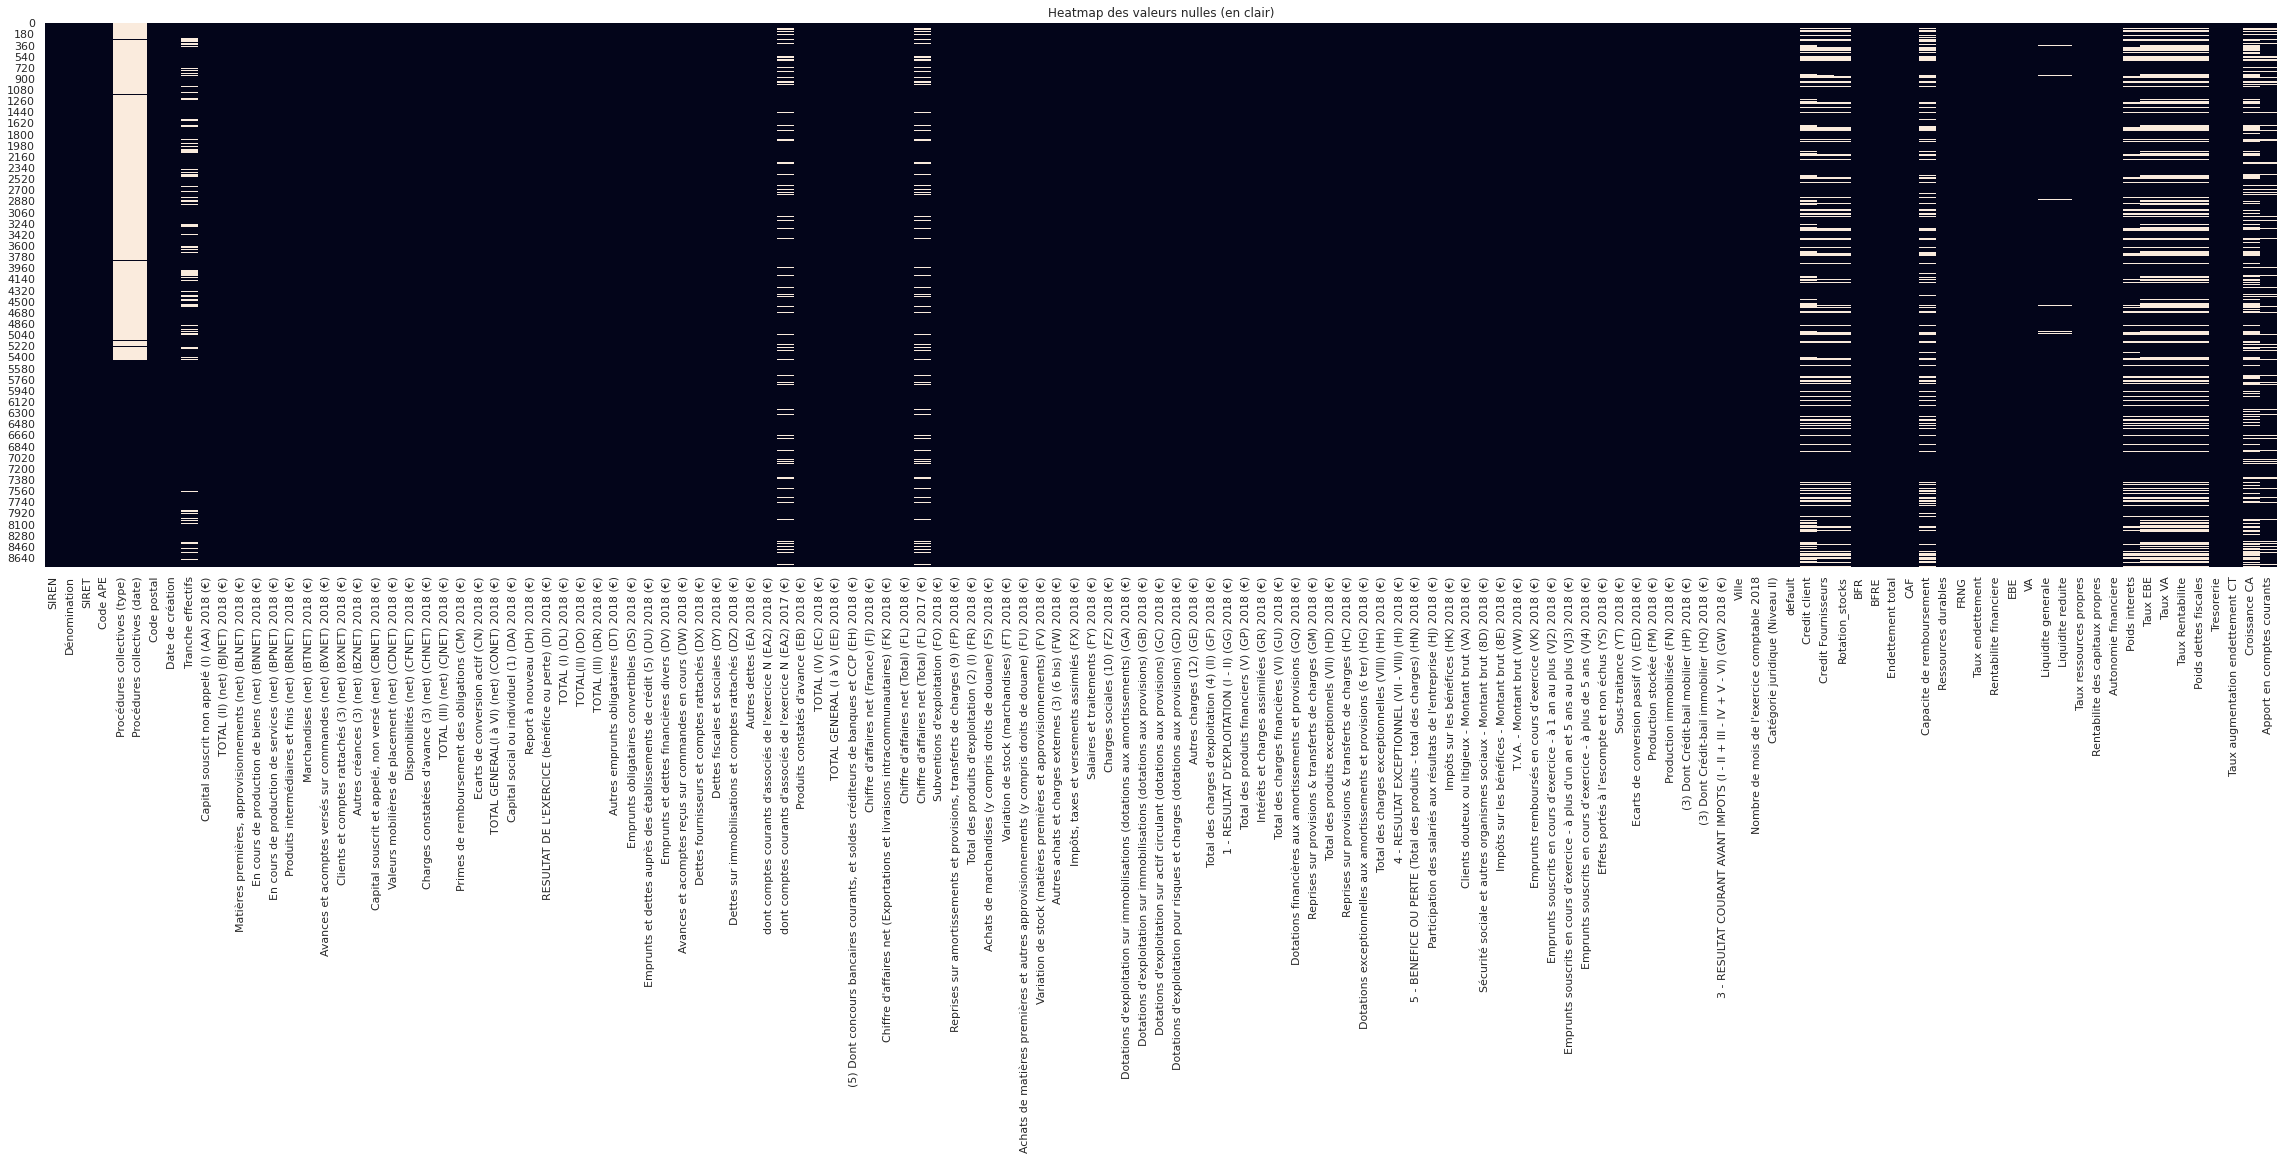

In [26]:
# heatmap des valeurs manquantes (en blanc)
plt.figure(figsize=(40,10))
sns.heatmap(df.isna(), cbar=False).set_title("Heatmap des valeurs nulles (en clair)")

In [27]:
# total de NaN sur le dataset
df.isna().sum().sum()/(df.shape[0]*df.shape[1])*100

3.4746555152324143

In [28]:
# taux de NaN par colonne
(df.isna().sum()/df.shape[0]).sort_values(ascending=False)

Procédures collectives (type)                                                                          0.61248
Procédures collectives (date)                                                                          0.61248
Croissance CA                                                                                          0.35679
Credit client                                                                                          0.29520
Poids dettes fiscales                                                                                  0.29520
Taux Rentabilite                                                                                       0.29520
Taux VA                                                                                                0.29520
Taux EBE                                                                                               0.29520
Capacite de remboursement                                                                              0.25296
C

### Focus sur les entreprises avec un CA null
- 2593 entreprises avec CA null 
- Les ratios calculés sur la base du CA sont donc NaN 
- Si on supprime ces entreprises, ça n'a pas d'impact sur la ventilation des entreprises selon la target (stable à 38% de défaillantes :

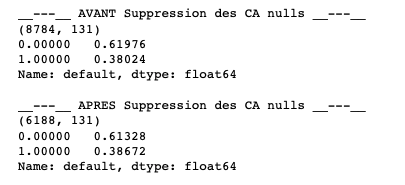

- Est-ce pertinent de garder ces entreprises ? Comment reformuler cette question ? 
    - Est ce que la distribution (entre des entreprises ayant un CA nul et celle n'en ayant pas est significativement différente ?
    
- Décision est prise de les supprimer car sur le plan économique c'est aussi justifié.
- Ca permet de faire passer le dataset de 3,47 à 1,45% de NaN

In [29]:
df_CA_not_null = df[df["Chiffre d'affaires net (Total) (FL) 2018 (€)"] > 0]

In [30]:
(df["Chiffre d'affaires net (Total) (FL) 2018 (€)"] == 0).sum()

2593

In [31]:
df_CA_not_null.shape

(6188, 131)

In [32]:
print("__---__ AVANT Suppression des CA nulls __---__")
print(df.shape)
print(df['default'].value_counts()/df.shape[0])

print("\n__---__ APRES Suppression des CA nulls __---__")
print(df_CA_not_null.shape)
print(df_CA_not_null['default'].value_counts()/df_CA_not_null.shape[0])

__---__ AVANT Suppression des CA nulls __---__
(8784, 131)
0.00000   0.61976
1.00000   0.38024
Name: default, dtype: float64

__---__ APRES Suppression des CA nulls __---__
(6188, 131)
0.00000   0.61328
1.00000   0.38672
Name: default, dtype: float64


In [33]:
# total de NaN sur le dataset après suppression des CA nulls
df_CA_not_null.isna().sum().sum()/(df_CA_not_null.shape[0]*df_CA_not_null.shape[1])*100

1.4525775078087606

In [34]:
# taux de NaN par colonne une fois les entreprises avec un CA null supprimées
(df_CA_not_null.isna().sum()/df_CA_not_null.shape[0]).sort_values(ascending=False)

Procédures collectives (type)                                                                          0.60617
Procédures collectives (date)                                                                          0.60617
Croissance CA                                                                                          0.15304
Tranche effectifs                                                                                      0.13219
Apport en comptes courants                                                                             0.12056
dont comptes courants d'associés de l'exercice N (EA2) 2017 (€)                                        0.12056
Chiffre d'affaires net (Total) (FL) 2017 (€)                                                           0.12056
Capacite de remboursement                                                                              0.02909
Liquidite reduite                                                                                      0.00485
L

### Focus sur les colonnes avec plus de 3% de NaN (gap entre 3% et 12% de NaN)
- Procédures collectives (type)                                                                          0.60617 => supprimer la colonne
- Procédures collectives (date)                                                                          0.60617 => supprimer la colonne
- Croissance CA                                                                                          0.15304 => supprimer la colonne (vient de l'absence d'info sur CA 2017)
- Tranche effectifs                                                                                      0.13219 => voir si imputation intéressante (plus fréquent). Sinon supprimer la colonne
- Apport en comptes courants                                                                             0.12056 => supprimer la colonne (vient de l'absence d'info sur CCA 2017)
- dont comptes courants d'associés de l'exercice N (EA2) 2017 (€)                                        0.12056 => supprimer la colonne
- Chiffre d'affaires net (Total) (FL) 2017 (€)                                                           0.12056 => supprimer la colonne

# Deuxième passe de modification des données
## Suppression des lignes avec un CA null

In [21]:
def suppr_nulls_nans(df):
    # suppression des entreprises avec CA null
    df = df[df["Chiffre d'affaires net (Total) (FL) 2018 (€)"] > 0]
    # suppression des colonnes avec plus de 12% de NaN (sauf tranche d'effectif)
    cols_null_to_drop = ["Procédures collectives (type)", 
                         "Procédures collectives (date)", 
                         "Croissance CA", 
                         "Apport en comptes courants", 
                         "dont comptes courants d'associés de l'exercice N (EA2) 2017 (€)", 
                         "Chiffre d'affaires net (Total) (FL) 2017 (€)"]
    df = df.drop(cols_null_to_drop, axis=1)
    # passage des valeurs infinies en nan
    df = df.replace([np.inf, -np.inf], np.nan)
    return df

In [22]:
df = suppr_nulls_nans(df)

In [23]:
df.shape

(6188, 125)

## Modifications du DF relatives aux catégories prenant trop de modalités

### Merge avec données NAF
Suite à l'analyse des variables catégorielles : 507 valeurs uniques. L'objectif est de réduire le nombre de modalités en travaillant à un niveau moins fin

In [24]:
def merge_naf(df, naf_path):
    df_naf = pd.read_excel(naf_path, header=[1])
    df_naf = df_naf.drop(["Unnamed: 10", "Unnamed: 11", "Unnamed: 12", "Unnamed: 13", "Unnamed: 14", "Unnamed: 15",
            "Unnamed: 16", "Unnamed: 17", "Unnamed: 18", "Unnamed: 19", "Unnamed: 20", "Unnamed: 21", "Unnamed: 22"], axis=1)
    df_naf = df_naf.rename(columns={'Unnamed: 1':'Descriptif A 732'})
    # Step 1 - suppression des points dans la colonne A 732
    # pour avoir le même format que dans les données d'entreprises
    for row in range(df_naf.shape[0]):
        df_naf.loc[row,'A 732'] = df_naf.loc[row,'A 732'].replace('.', '')
    # Step 2 - Join avec le dataset d'entreprises 
    # (pour la mise en DB, il faudra créér deux tables et faire les joins dans la requête SQL)
    df_merged = pd.merge(df, df_naf, how = 'left', left_on = df['Code APE'], right_on = df_naf['A 732'])
    df_merged = df_merged.drop(['key_0'], axis=1)
    assert df_merged.shape[0]==df.shape[0]
    assert df_merged.shape[1]==df.shape[1]+df_naf.shape[1]
    return df_merged, df_naf

In [25]:
df, df_naf = merge_naf(df, naf_path="./table_NAF2-NA.xls")

### Date de création => rajout d'une colonne sur l'âge
Date de création initialement en catégorie. Passée en date, et utilisation pour calculer l'âge au 31/12/2019

In [26]:
import datetime
def ajout_col_age(df):
    df["Date de création"] = pd.to_datetime(df["Date de création"])
    df["Age entreprise"] = ((datetime.datetime(2019,12,31) - df["Date de création"])/np.timedelta64(1, 'M'))
    df["Age entreprise"] = df["Age entreprise"].astype(int)
    return df

In [27]:
df = ajout_col_age(df)

### Effectif moyen => passage en ordinal

In [28]:
def effectif_encoder(df):
    dic_effectif = { "0 salarié pendant l'année" : 0
                , "0 salarié à la fin de l'année" : 1
                , "De 1 à 2 salariés" : 2
                , "De 3 à 5 salariés" : 3
                , "De 6 à 9 salariés" : 4
                , "De 10 à 19 salariés" : 5
                , "De 20 à 49 salariés" : 6
                , "De 50 à 99 salariés" : 7
                , "De 100 à 199 salariés" : 8
                , "De 200 à 249 salariés" : 9
                , "De 250 à 499 salariés" : 10
                , "De 500 à 999 salariés" : 11
                , "De 1000 à 1999 salariés" : 12
                , "De 2000 à 4999 salariés" : 13 
    }
    df["Tranche effectifs"] = df["Tranche effectifs"].map(dic_effectif)
    return df

In [29]:
df = effectif_encoder(df)

# EDA - Analyse de forme

 Analyse de Forme :
- **variable target** : default (1 si défaillante, 0 sinon)
- **variables catégorielles** :On ne conserve que la catégorie juridique, après avoir fait un crosstab pour valider la pertinence de l'information.

## Variables catégorielles
- Tranche effectif => encodage ordinal (fait par dictionnaire, il faudra ensuite le refaire avec un ordinal encoder)
- Code A 21 => encodage ordinal
- Catégorie juridique => prévoir encodage one hot (11 modalités)
- Toutes les autres variables catégorielles => à supprimer

## Variables numériques
- 

In [44]:
df.describe()

SIREN                SIRET  Code postal  Tranche effectifs  Capital souscrit non appelé (I) (AA) 2018 (€)  TOTAL (II) (net) (BJNET) 2018 (€)  Matières premières, approvisionnements (net) (BLNET) 2018 (€)  En cours de production de biens (net) (BNNET) 2018 (€)  En cours de production de services (net) (BPNET) 2018 (€)  Produits intermédiaires et finis (net) (BRNET) 2018 (€)  Marchandises (net) (BTNET) 2018 (€)  Avances et acomptes versés sur commandes (net) (BVNET) 2018 (€)  Clients et comptes rattachés (3) (net) (BXNET) 2018 (€)  Autres créances (3) (net) (BZNET) 2018 (€)  Capital souscrit et appelé, non versé (net) (CBNET) 2018 (€)  Valeurs mobilières de placement (net) (CDNET) 2018 (€)  Disponibilités (net) (CFNET) 2018 (€)  Charges constatées d'avance (3) (net) (CHNET) 2018 (€)  TOTAL (III) (net) (CJNET) 2018 (€)  Primes de remboursement des obligations (CM) 2018 (€)  Ecarts de conversion actif (CN) 2018 (€)  TOTAL GENERAL(I à VI) (net) (CONET) 2018 (€)  \
count      6188.00000           6188.00000   6186.00000         5370.00000                                     6188.00000                         6188.00000                                         6188.00000                                                     6188.00000                                              6188.00000                                                 6188.00000                                 6188.00000                                         6188.00000                                                       6188.00000                                        6188.00000                                         6188.00000                                                    6188.00000                                  6188.00000                                         6188.00000                               6188.00000                                         6188.00000                                    6188.00000                                    6188.00000   
mean  536194033.95184 53619403395210.89844  56432.86987            2.93520                                       76.64253                      1183160.12314                                        52334.89350                                                    32882.66031                                              3683.29573                                                31496.06787                               140287.05414                                        12229.95152                                                     333379.68697                                      435075.96622                                           68.47366                                                   37243.97786                                169358.75727                                        17626.28151                            1269805.82062                                          968.08306                                    4665.13494                                 2580433.63946   
std   163714439.66762 16371443966756.03906  28793.34421            1.96465                                     4040.19324                     17844374.97545                                       448983.95959                                                   468590.90308                                             77844.38130                                               590276.66709                              2756503.66518                                       269443.29055                                                    1514700.83423                                     5051390.09823                                         4711.54117                                                  431699.16926                                850297.27565                                       167744.13717                            7962745.50263                                        59097.52638                                  230385.41296                                24772590.20246   
min     5520242.00000   552024200016.00000   1000.00000 

In [45]:
for col in df.select_dtypes(np.number):
    print(col)

SIREN
SIRET
Code postal
Tranche effectifs
Capital souscrit non appelé (I) (AA) 2018 (€)
TOTAL (II) (net) (BJNET) 2018 (€)
Matières premières, approvisionnements (net) (BLNET) 2018 (€)
En cours de production de biens (net) (BNNET) 2018 (€)
En cours de production de services (net) (BPNET) 2018 (€)
Produits intermédiaires et finis (net) (BRNET) 2018 (€)
Marchandises (net) (BTNET) 2018 (€)
Avances et acomptes versés sur commandes (net) (BVNET) 2018 (€)
Clients et comptes rattachés (3) (net) (BXNET) 2018 (€)
Autres créances (3) (net) (BZNET) 2018 (€)
Capital souscrit et appelé, non versé (net) (CBNET) 2018 (€)
Valeurs mobilières de placement (net) (CDNET) 2018 (€)
Disponibilités (net) (CFNET) 2018 (€)
Charges constatées d'avance (3) (net) (CHNET) 2018 (€)
TOTAL (III) (net) (CJNET) 2018 (€)
Primes de remboursement des obligations (CM) 2018 (€)
Ecarts de conversion actif (CN) 2018 (€)
TOTAL GENERAL(I à VI) (net) (CONET) 2018 (€)
Capital social ou individuel (1) (DA) 2018 (€)
Report à nouveau 

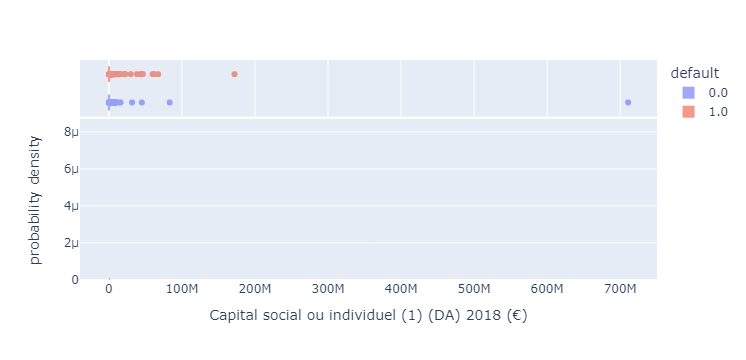

In [46]:
import plotly.express as px
fig = px.histogram(df, x=df["Capital social ou individuel (1) (DA) 2018 (€)"], color="default", nbins=6000, histnorm='probability density', marginal="box")
fig.update_traces(opacity=0.6)
fig.show()

# Analyse plus poussée - première identification des variables à supprimer

## Vérification de l'intérêt de la colonne Catégorie juridique dans les variables catégorielles
On conserve cette variable dont la distriubution varie selon la target (voir SA à CA par exemple)

In [47]:
pd.crosstab(df['default'], df['Catégorie juridique (Niveau II)'], margins=True, margins_name="Total")

Catégorie juridique (Niveau II)  Autre personne morale de droit privé  Entrepreneur individuel  Personne morale de droit étranger, immatriculée au RCS (registre du commerce et des sociétés)  Société anonyme à conseil d'administration  Société anonyme à directoire  Société civile  Société coopérative agricole  Société en commandite  Société en nom collectif  Société par actions simplifiée  Société à responsabilité limitée (SARL)  Total
default                                                                                                                                                                                                                                                                                                                                                                                                                                               
0.0                                                                 1                       35                                                  2                                                                                      54                             7              11                             1                      1                        37                             873                                     2773   3795
1.0                                                                 0                        7                                                  0                                                                                      84                             8               1                             1                     36                         5                             875                                     1376   2393
Total                                                               1                       42                                                  2                                                                                     138                            15              12                             2                     37                        42                            1748                                     4149   6188

In [48]:
pd.crosstab(df['default'], df['Catégorie juridique (Niveau II)'], normalize='columns', margins=True, margins_name="Total")

Catégorie juridique (Niveau II)  Autre personne morale de droit privé  Entrepreneur individuel  Personne morale de droit étranger, immatriculée au RCS (registre du commerce et des sociétés)  Société anonyme à conseil d'administration  Société anonyme à directoire  Société civile  Société coopérative agricole  Société en commandite  Société en nom collectif  Société par actions simplifiée  Société à responsabilité limitée (SARL)   Total
default                                                                                                                                                                                                                                                                                                                                                                                                                                                
0.00000                                                       1.00000                  0.83333                                            1.00000                                                                                 0.39130                       0.46667         0.91667                       0.50000                0.02703                   0.88095                         0.49943                                  0.66835 0.61328
1.00000                                                       0.00000                  0.16667                                            0.00000                                                                                 0.60870                       0.53333         0.08333                       0.50000                0.97297                   0.11905                         0.50057                                  0.33165 0.38672

In [49]:
def remove_useless_cols_v1(df):
    useless_cols = [
        "Dénomination",
        "Tranche effectifs",
        "Ville",
        "Emprunts remboursés en cours d’exercice (VK) 2018 (€)",
        "SIREN",
        "SIRET",
        "Code postal",
        "Emprunts souscrits en cours d’exercice - à 1 an au plus (VJ2) 2018 (€)",
        "Emprunts souscrits en cours d’exercice - à plus d'un an et 5 ans au plus (VJ3) 2018 (€)",
        "Emprunts souscrits en cours d’exercice - à plus de 5 ans (VJ4) 2018 (€)"
    ]
    
    df = df.drop(useless_cols, axis=1)
    return df

In [50]:
df = remove_useless_cols_v1(df)

## Première identification des variables les plus explicatives / de celles à supprimer
- Calcul des corrélations avec la target. 
    - **CODES APE**
        - On voit que les **codes d'activité** semblent être ordonnés et semblent avoir un impact sur la probabilité de défault. Ils se démarquent nettement des autres données chiffrées et méritent qu'on se focalise un peu plus dessus.
        - On cherche à tester cette hypothèse avec des visualisations sur les distributions de ces variables selon la target. 
        - On réalise plusieurs crosstabs pour identifier la distribution des 0/1 au sein de chaque code. On fait ça à plusieurs niveaux de granularité, pour finalement sélectionner le niveau de l'A 21 comme étant un bon compromis entre nombre de modalités et capacité à discriminer les défaillantes des saines. 
        - On décide dans un premier temps d'encoder ordinalement cette catégorie, en effectuant un tri sur le % de défaillantes dans chaque modalité. On arrive alors à un coefficient de corrélation très intéressant : Mais, pour éviter le data leakage, il faudra tester également le one hot encoder.
        - On voit notamment que les entreprises des industries manufacturières sont nettement plus nombreuses dans le camp des défaillantes.
   - **Dettes fiscales et sociales**
       - Graphiques permettent de voir les différences de distributions selon la défaillance.
       - A voir si on conserve le montant ou si on utilise le taux. Les résultats sont compliqués à interpréter.

In [51]:
corr = df.corr()

In [52]:
corr['default'].sort_values()

A 88                                                                                                   -0.12514
A 272                                                                                                  -0.12480
A 615                                                                                                  -0.12476
RESULTAT DE L'EXERCICE (bénéfice ou perte) (DI) 2018 (€)                                               -0.12303
5 - BENEFICE OU PERTE (Total des produits - total des charges) (HN) 2018 (€)                           -0.12295
1 - RESULTAT D'EXPLOITATION (I - II) (GG) 2018 (€)                                                     -0.11557
3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2018 (€)                           -0.10861
Report à nouveau (DH) 2018 (€)                                                                         -0.09556
CAF                                                                                                    -

### APE // target
 - On voit que les **codes d'activité** semblent être ordonnés et semblent avoir un impact sur la probabilité de défault. Ils se démarquent nettement des autres données chiffrées et méritent qu'on se focalise un peu plus dessus.
        - On cherche à tester cette hypothèse avec des visualisations sur les distributions de ces variables selon la target. 
        - On réalise plusieurs crosstabs pour identifier la distribution des 0/1 au sein de chaque code. On fait ça à plusieurs niveaux de granularité, pour finalement sélectionner le niveau de l'A 21 comme étant un bon compromis entre nombre de modalités et capacité à discriminer les défaillantes des saines. 
        - On décide dans un premier temps d'encoder ordinalement cette catégorie, en effectuant un tri sur le % de défaillantes dans chaque modalité. On arrive alors à un coefficient de corrélation très intéressant : Mais, pour éviter le data leakage, il faudra tester également le one hot encoder.
        - On voit notamment que les entreprises des industries manufacturières sont nettement plus nombreuses dans le camp des défaillantes.

#### Choix du niveau de granularité

In [53]:
pd.crosstab(df['default'], df['A 64'], margins=True, margins_name="Total")

A 64     AZ1  AZ2  BZ0  CA0  CB0  CC1  CC2  CC3  CE0  CG1  CG2  CH1  CH2  CI0  CJ0  CK0  CL1  CL2  CM1  CM2  DZ0  EZ2  FZ0  GZ1  GZ2  GZ3  HZ1  HZ2  HZ4  HZ5  IZ0  JA1  JA2  JB0  JC0  KZ1  KZ2  KZ3  LZ0  MA1  MA2  MB0  MC1  MC2  NZ1  NZ2  NZ3  NZ4  OZ0  PZ0  QA0  QB0  RZ1  RZ2  SZ2  SZ3  Total
default                                                                                                                                                                                                                                                                                               
0.0        1    6    5   68   16   15    5   14    6    5   13    3   53   10    5   11    3    0   27   32   48    7  497  149  266  383   72    3   22    0  400   15   29    4   90  249    1   58  288  223  122    4   26   48   42   15   20  139    1   38   39   13   14   32   25  115   3795
1.0        1    1    0   77   24   14    3   25    7   16   12    7   76    8    7   11    5    2   17   26    3   12  442   74  148  262   74    1   14    3  303   21   24    2   32  134    0   13   49   76   54    4   25   19   17    5    7   79    0   40   10    9    6   22    5   65   2393
Total      2    7    5  145   40   29    8   39   13   21   25   10  129   18   12   22    8    2   44   58   51   19  939  223  414  645  146    4   36    3  703   36   53    6  122  383    1   71  337  299  176    8   51   67   59   20   27  218    1   78   49   22   20   54   30  180   6188

In [54]:
pd.crosstab(df['default'], df['A 38'], margins=True, margins_name="Total")

A 38     AZ  BZ   CA  CB  CC  CE  CG   CH  CI  CJ  CK  CL   CM  DZ  EZ   FZ    GZ   HZ   IZ  JA  JB   JC   KZ   LZ   MA  MB   MC   NZ  OZ  PZ  QA  QB  RZ   SZ  Total
default                                                                                                                                                              
0.0       7   5   68  16  34   6  18   56  10   5  11   3   59  48   7  497   798   97  400  44   4   90  308  288  345   4   74  216   1  38  39  13  46  140   3795
1.0       2   0   77  24  42   7  28   83   8   7  11   7   43   3  12  442   484   92  303  45   2   32  147   49  130   4   44  108   0  40  10   9  28   70   2393
Total     9   5  145  40  76  13  46  139  18  12  22  10  102  51  19  939  1282  189  703  89   6  122  455  337  475   8  118  324   1  78  49  22  74  210   6188

In [55]:
# à comparer aux taux normaux, à savoir 38% de 1 et 62% de 0
pd.crosstab(df['default'], df['A 38'], normalize='columns')

A 38         AZ      BZ      CA      CB      CC      CE      CG      CH      CI      CJ      CK      CL      CM      DZ      EZ      FZ      GZ      HZ      IZ      JA      JB      JC      KZ      LZ      MA      MB      MC      NZ      OZ      PZ      QA      QB      RZ      SZ
default                                                                                                                                                                                                                                                                                
0.00000 0.77778 1.00000 0.46897 0.40000 0.44737 0.46154 0.39130 0.40288 0.55556 0.41667 0.50000 0.30000 0.57843 0.94118 0.36842 0.52929 0.62246 0.51323 0.56899 0.49438 0.66667 0.73770 0.67692 0.85460 0.72632 0.50000 0.62712 0.66667 1.00000 0.48718 0.79592 0.59091 0.62162 0.66667
1.00000 0.22222 0.00000 0.53103 0.60000 0.55263 0.53846 0.60870 0.59712 0.44444 0.58333 0.50000 0.70000 0.42157 0.05882 0.63158 0.47071 0.37754 0.48677 0.43101 0.50562 0.33333 0.26230 0.32308 0.14540 0.27368 0.50000 0.37288 0.33333 0.00000 0.51282 0.20408 0.40909 0.37838 0.33333

In [56]:
pd.crosstab(df['default'], df['A 21'], margins=True, margins_name="Total")

A 21     A  B    C   D   E    F     G    H    I    J    K    L    M    N  O   P   Q   R    S  Total
default                                                                                            
0.0      7  5  286  48   7  497   798   97  400  138  308  288  423  216  1  38  52  46  140   3795
1.0      2  0  337   3  12  442   484   92  303   79  147   49  178  108  0  40  19  28   70   2393
Total    9  5  623  51  19  939  1282  189  703  217  455  337  601  324  1  78  71  74  210   6188

In [30]:
pd.crosstab(df['default'], df['A 21'], margins=True, normalize='columns', margins_name="Total")

A 21          A       B       C       D       E       F       G       H       I       J       K       L       M       N       O       P       Q       R       S   Total
default                                                                                                                                                                
0.00000 0.77778 1.00000 0.45907 0.94118 0.36842 0.52929 0.62246 0.51323 0.56899 0.63594 0.67692 0.85460 0.70383 0.66667 1.00000 0.48718 0.73239 0.62162 0.66667 0.61328
1.00000 0.22222 0.00000 0.54093 0.05882 0.63158 0.47071 0.37754 0.48677 0.43101 0.36406 0.32308 0.14540 0.29617 0.33333 0.00000 0.51282 0.26761 0.37838 0.33333 0.38672

#### Tri et encodage des A 21

In [57]:
cross_21 = pd.crosstab(df['default'], df['A 21'], normalize='columns')
cross_21 = cross_21.transpose()
cross_21["saines"] = cross_21[0]
cross_21["saines"].sort_values()

A 21
E   0.36842
C   0.45907
P   0.48718
H   0.51323
F   0.52929
I   0.56899
R   0.62162
G   0.62246
J   0.63594
N   0.66667
S   0.66667
K   0.67692
M   0.70383
Q   0.73239
A   0.77778
L   0.85460
D   0.94118
O   1.00000
B   1.00000
Name: saines, dtype: float64

In [58]:
# cet encodage donne un très bon résultat (on est à -0,19647 de corrélation avec la target) mais 
# peut-etre est-ce un peu du data leakage et de la "triche".
# tester donc aussi un one hot encoder sur ce sujet pour limiter la partie "triche". En tout cas ce niveau 
# granularité semble suffisant.

## PARTIR SUR UNE CLASSIFICATION MOINS FINE
def encode_naf21(df):
    dict_naf21 = {'C':0,
                  'E':1,
                  'P':2,
                  'H':3,
                  'F':4,
                  'I':5,
                  'R':6,
                  'G':7,
                  'N':8,
                  'J':9,
                  'S':10,
                  'Q':11,
                  'M':12,
                  'K':13,
                  'A':14,
                  'L':15,
                  'D':16,
                  'O':17,
                  'B':18
    }
    df["A 21 encoded"] = df["A 21"].map(dict_naf21)
    return df

In [59]:
df = encode_naf21(df)

#### Relation target / A 21 => comment interpréter ?
- On a un relativement bon taux de corrélation (-0,19)
- Mais une régression logistique ne semble pas pouvoir expliquer grand chose : on n'a pas du tout de sinusoidale, et le pseudo R2 est très très moche
- Enfin quand on réalise la régression logistique avec SKLearn on a tout de même un accuracy de 0,6, avec un F1 score de 0,21 sur les 1.

In [60]:
# CORRELATION de -0.19647055894530227
df["default"].corr(df["A 21 encoded"])

-0.19690022038189203

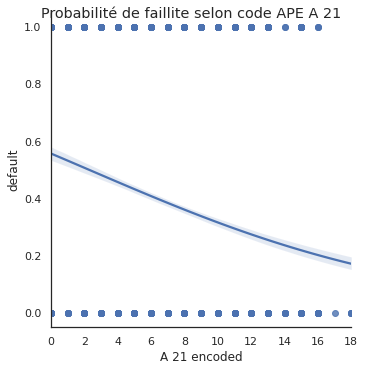

In [61]:
sns.lmplot(data=df, x="A 21 encoded", y ='default', logistic=True).fig.suptitle('Probabilité de faillite selon code APE A 21')
plt.show()

In [62]:
# building the model and fitting the data
import statsmodels.api as sm
import statsmodels.formula.api as smf

df_temp = df.copy()
df_temp = df_temp.rename(columns={'A 21 encoded':'A21'})

f = 'default ~ A21'
logitfit = smf.logit(formula = str(f), data = df_temp).fit()

# Inspecte les résultats 
logitfit.summary()

Optimization terminated successfully.
         Current function value: 0.647434
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                 6188
Model:                          Logit   Df Residuals:                     6186
Method:                           MLE   Df Model:                            1
Date:                Wed, 31 Aug 2022   Pseudo R-squ.:                 0.02971
Time:                        13:45:50   Log-Likelihood:                -4006.3
converged:                       True   LL-Null:                       -4129.0
Covariance Type:            nonrobust   LLR p-value:                 2.724e-55
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2309      0.051      4.486      0.000       0.130       0.332
A21           -0.1000      0.007    -15.237      0.000      -0.113      -0.087
==============================================================================
"""

In [63]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

In [64]:
#### Train test split

from sklearn.model_selection import train_test_split

# on peut dans un premier temps séparer en 2 le dataset :
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

In [65]:
# Modèle 1 : régression logistique juste sur l' A 21 encodé à la main en ordinal

model_1 = LogisticRegression()

X1_train = trainset[["A 21 encoded"]]
y1_train = trainset["default"]
X1_test = testset[["A 21 encoded"]]
y1_test = testset["default"]

In [66]:
# Modèle 2 : régression logistique juste sur l'A 21, mais cette fois encodé en one hot

model_2 = make_pipeline(OneHotEncoder(handle_unknown='ignore'), LogisticRegression())

X2_train = trainset[["A 21"]]
y2_train = trainset["default"]
X2_test = testset[["A 21"]]
y2_test = testset["default"]

__---__ CONFUSION MATRIX __---__
          Predicted 0  Predicted 1  TOTAL
Actual 0          685           71    756
Actual 1          407           75    482
TOTAL            1092          146   1238

__---__ CLASSIFICATION REPORT __---__
              precision    recall  f1-score   support

         0.0       0.63      0.91      0.74       756
         1.0       0.51      0.16      0.24       482

    accuracy                           0.61      1238
   macro avg       0.57      0.53      0.49      1238
weighted avg       0.58      0.61      0.55      1238



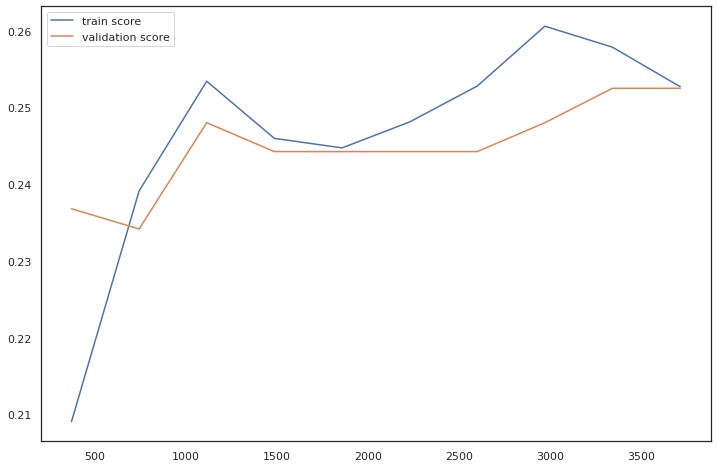

In [67]:
evaluate(model_1, X1_train, y1_train, X1_test, y1_test)

__---__ CONFUSION MATRIX __---__
          Predicted 0  Predicted 1  TOTAL
Actual 0          685           71    756
Actual 1          407           75    482
TOTAL            1092          146   1238

__---__ CLASSIFICATION REPORT __---__
              precision    recall  f1-score   support

         0.0       0.63      0.91      0.74       756
         1.0       0.51      0.16      0.24       482

    accuracy                           0.61      1238
   macro avg       0.57      0.53      0.49      1238
weighted avg       0.58      0.61      0.55      1238



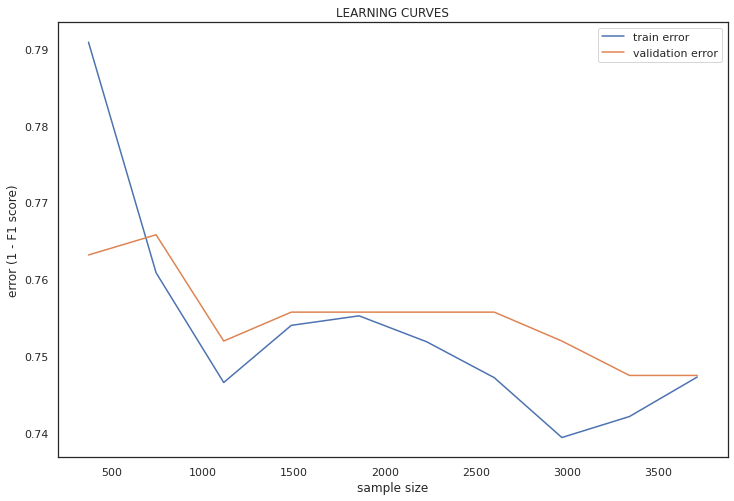

In [68]:
evaluate2(model_1, X1_train, y1_train, X1_test, y1_test)

__---__ CONFUSION MATRIX __---__
          Predicted 0  Predicted 1  TOTAL
Actual 0          691           65    756
Actual 1          417           65    482
TOTAL            1108          130   1238

__---__ CLASSIFICATION REPORT __---__
              precision    recall  f1-score   support

         0.0       0.62      0.91      0.74       756
         1.0       0.50      0.13      0.21       482

    accuracy                           0.61      1238
   macro avg       0.56      0.52      0.48      1238
weighted avg       0.58      0.61      0.54      1238



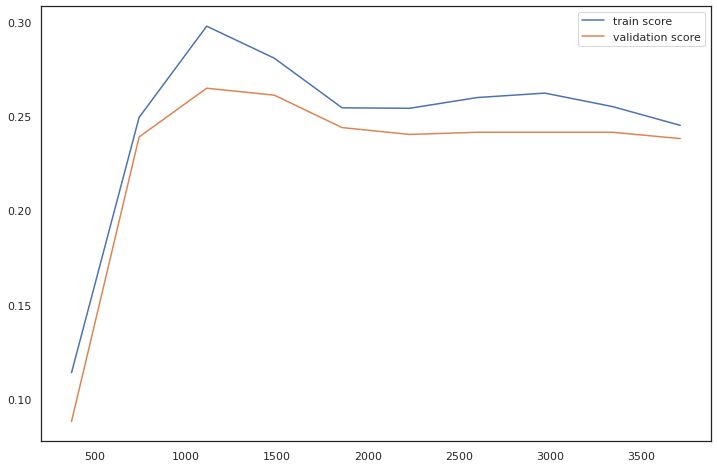

In [69]:
evaluate(model_2, X2_train, y2_train, X2_test, y2_test)

__---__ CONFUSION MATRIX __---__
          Predicted 0  Predicted 1  TOTAL
Actual 0          691           65    756
Actual 1          417           65    482
TOTAL            1108          130   1238

__---__ CLASSIFICATION REPORT __---__
              precision    recall  f1-score   support

         0.0       0.62      0.91      0.74       756
         1.0       0.50      0.13      0.21       482

    accuracy                           0.61      1238
   macro avg       0.56      0.52      0.48      1238
weighted avg       0.58      0.61      0.54      1238



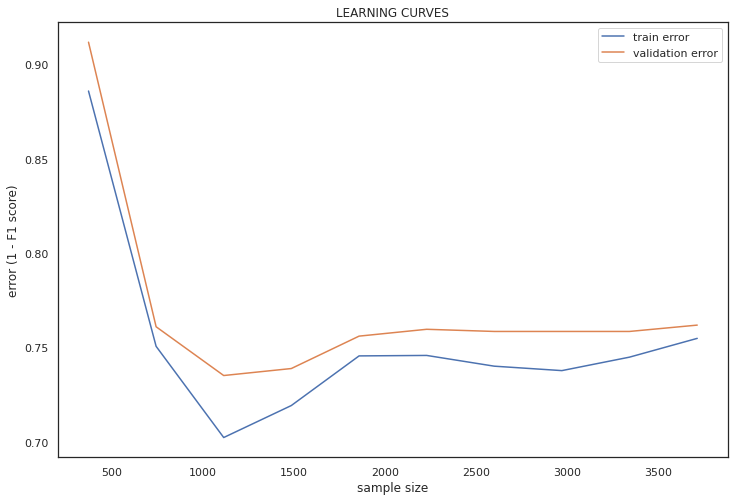

In [70]:
evaluate2(model_2, X2_train, y2_train, X2_test, y2_test)

### Dettes fiscales et sociales et target
- Le graphe confirme bien que **le montant des dettes fiscales et sociales est distribué différemment selon que l'on est une entreprise saine ou défaillante.** 
- On voit que les outliers sont davantage du côté des entreprises défaillantes mais qu'il y en a quand même un certain nombre chez les saines. Peut-être intéressant de plutôt calculer le poids des dettes dans le CA. On observe effectivement que ca resserre les données des entreprises saines tout en étalant au contraire celles des entreprises défaillantes.
- Mais après cette opération le coeff de corrélation est divisé par 2 (de 0,12 à 0,06)
- On approfondit avec une régression logistique toute simple sur chaque colonne
- L'accuracy est meilleure avec le taux, mais le recall est catastrophique (0.7). Et c'est surtout cet élément qui est déterminant pour nous. On a donc un faisceau d'éléments nous poussant à conserver plutôt le montant de dettes fiscales et sociales qui semble être plus discriminant que leur taux

In [1]:
eda = df.copy()

NameError: name 'df' is not defined

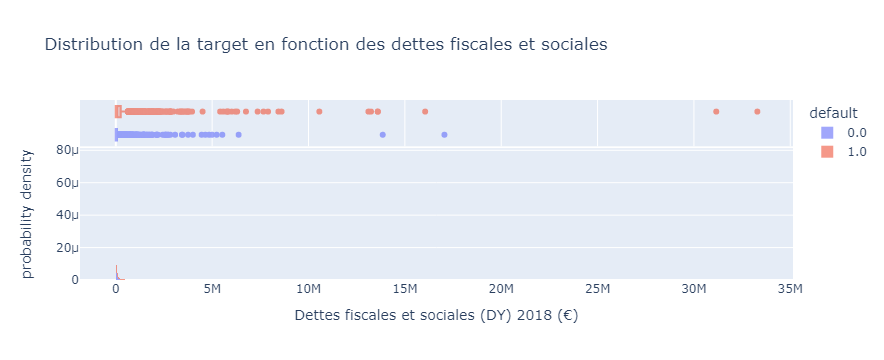

In [81]:
# AVEC PLOTLY (oui à conserver)
import plotly.express as px
fig = px.histogram(eda, x=eda['Dettes fiscales et sociales (DY) 2018 (€)'], color="default", nbins=6000, histnorm='probability density', marginal="box", title="Distribution de la target en fonction des dettes fiscales et sociales")
fig.update_traces(opacity=0.6)
fig.show()

In [76]:
eda["Taux dettes fiscales sur CA"] = eda['Dettes fiscales et sociales (DY) 2018 (€)'] / eda["Chiffre d'affaires net (Total) (FL) 2018 (€)"]

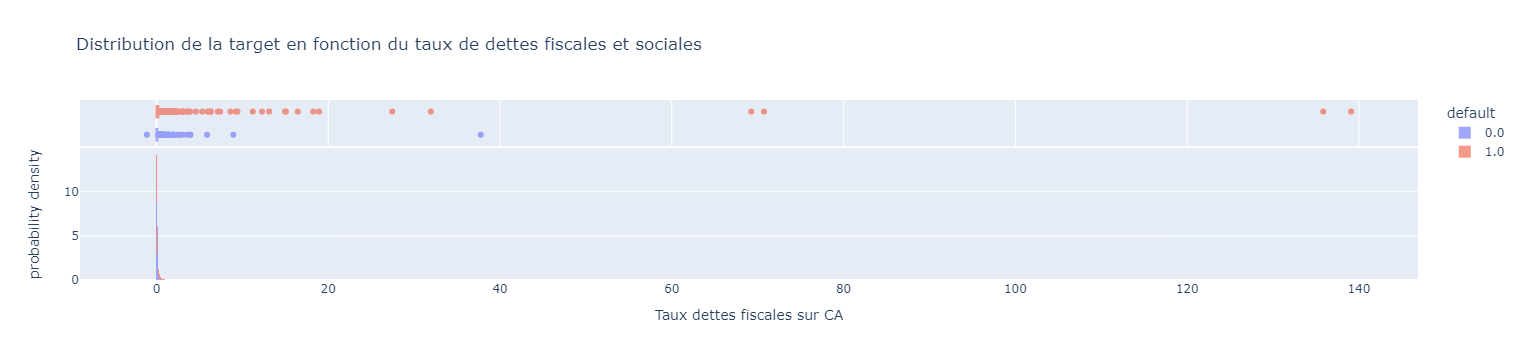

In [82]:
import plotly.express as px
fig = px.histogram(eda, x=eda["Taux dettes fiscales sur CA"], color="default", nbins=6000, histnorm='probability density', marginal="box", title="Distribution de la target en fonction du taux de dettes fiscales et sociales")
fig.update_traces(opacity=0.6)
fig.show()

In [78]:
eda["default"].corr(eda["Taux dettes fiscales sur CA"])

0.06275977630604967

In [79]:
eda["default"].corr(eda['Dettes fiscales et sociales (DY) 2018 (€)'])

0.12596989023176047

In [83]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression


model_3 = LogisticRegression()
model_4 = LogisticRegression()

In [84]:
#### Train test split => on en refait un car rajout de la colonne Taux de dettes fiscales dans le df eda

from sklearn.model_selection import train_test_split

# on peut dans un premier temps séparer en 2 le dataset :
trainset, testset = train_test_split(eda, test_size=0.2, random_state=0)

# on vérifie que la distribution de la target reste OK dans les test et train set => c'est OK
trainset['default'].value_counts(normalize=True)

testset['default'].value_counts(normalize=True)

0.00000   0.61066
1.00000   0.38934
Name: default, dtype: float64

In [85]:
# modèle 3 : régression logistique sur le taux

X3_train = trainset[["Taux dettes fiscales sur CA"]]
y3_train = trainset["default"]
X3_test = testset[["Taux dettes fiscales sur CA"]]
y3_test = testset["default"]

In [86]:
# modèle 4 : régression logistique sur la valeur

X4_train = trainset[['Dettes fiscales et sociales (DY) 2018 (€)']]
y4_train = trainset["default"]
X4_test = testset[['Dettes fiscales et sociales (DY) 2018 (€)']]
y4_test = testset["default"]

__---__ CONFUSION MATRIX __---__
          Predicted 0  Predicted 1  TOTAL
Actual 0          744           12    756
Actual 1          446           36    482
TOTAL            1190           48   1238

__---__ CLASSIFICATION REPORT __---__
              precision    recall  f1-score   support

         0.0       0.63      0.98      0.76       756
         1.0       0.75      0.07      0.14       482

    accuracy                           0.63      1238
   macro avg       0.69      0.53      0.45      1238
weighted avg       0.67      0.63      0.52      1238



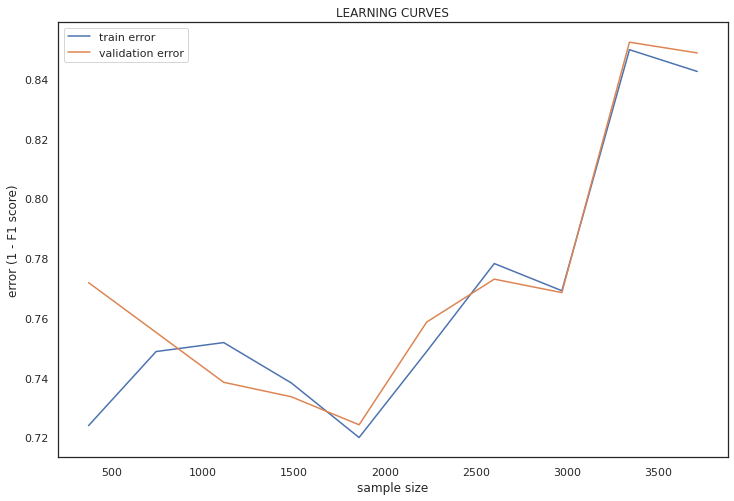

In [87]:
evaluate2(model_3, X3_train, y3_train, X3_test, y3_test)

__---__ CONFUSION MATRIX __---__
          Predicted 0  Predicted 1  TOTAL
Actual 0          268          488    756
Actual 1          104          378    482
TOTAL             372          866   1238

__---__ CLASSIFICATION REPORT __---__
              precision    recall  f1-score   support

         0.0       0.72      0.35      0.48       756
         1.0       0.44      0.78      0.56       482

    accuracy                           0.52      1238
   macro avg       0.58      0.57      0.52      1238
weighted avg       0.61      0.52      0.51      1238



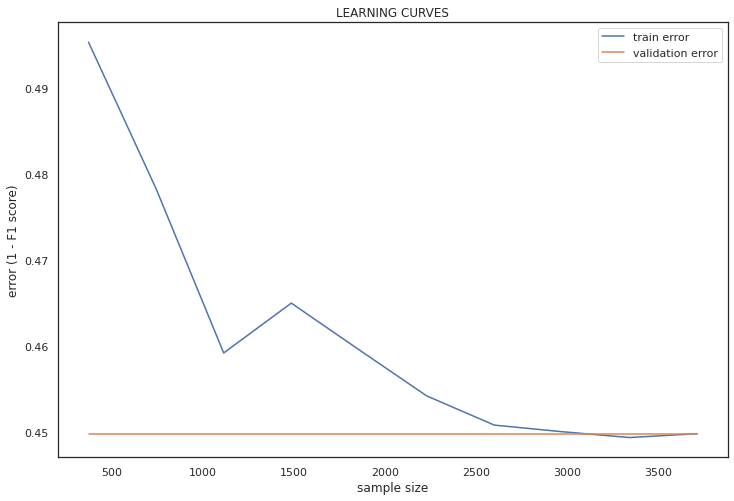

In [88]:
evaluate2(model_4, X4_train, y4_train, X4_test, y4_test)

# Troisième passe de modification des données : suppression des outliers et des colonnes totalement inutiles


## Suppression des colonnes inutiles
- Codes NAF : on ne garde que l'A 21 suite à étude réalisée
- Dénomination, CSIRET, SIREN, Ville, Code postal n'apportent pas d'information
- Emprunts souscris / remboursés au cours de l'exercice : trop de valeurs manquantes

In [71]:
def remove_useless_cols_round2(df):
    useless_cols = [
        "Descriptif A 732",
        "A 732",
        "A 615",
        "A 272",
        "A 129",
        "A 88",
        "A 64",
        "A 38",
        "A 10"
    ]
    
    df = df.drop(useless_cols, axis=1)
    return df

## Suppression des outliers

Après examen visuel des distributions, on remarque qu'il y a toujours quelques valeurs très extrêmes. On décide de ne supprimer que les valeurs les plus extrêmes, à plus ou moins 20 écart type de la moyenne.
Ce choix de +- 20 écart type est fait par tatonnement, pour ne pas supprimer trop de lignes mais rester quand même dans le dataset

In [72]:
def count_outliers(df, col):
    mean = np.mean(df[col], axis=0)
    sd = np.std(df[col], axis=0)
    minimum = mean - 20 * sd
    maximum = mean + 20 * sd
    df_outliers = df.loc[(df[col] <= minimum) | (df[col] >= maximum)]
    return df_outliers.shape[0]

def remove_outliers(df, col):
    mean = np.mean(df[col], axis=0)
    sd = np.std(df[col], axis=0)
    minimum = mean - 20 * sd
    maximum = mean + 20 * sd
    df = df.loc[(df[col] > minimum) & (df[col] < maximum)]
    return df

In [73]:
df2 = remove_useless_cols_round2(df)

In [74]:
# suppression des outliers de +- 20 écart type : on passe de 6188 à 5740
for col in df2.select_dtypes(np.number):
    df2 = remove_outliers(df2, col)
    print(col, df2.shape[0])

Capital souscrit non appelé (I) (AA) 2018 (€) 6186
TOTAL (II) (net) (BJNET) 2018 (€) 6185
Matières premières, approvisionnements (net) (BLNET) 2018 (€) 6181
En cours de production de biens (net) (BNNET) 2018 (€) 6179
En cours de production de services (net) (BPNET) 2018 (€) 6177
Produits intermédiaires et finis (net) (BRNET) 2018 (€) 6174
Marchandises (net) (BTNET) 2018 (€) 6173
Avances et acomptes versés sur commandes (net) (BVNET) 2018 (€) 6171
Clients et comptes rattachés (3) (net) (BXNET) 2018 (€) 6169
Autres créances (3) (net) (BZNET) 2018 (€) 6165
Capital souscrit et appelé, non versé (net) (CBNET) 2018 (€) 6164
Valeurs mobilières de placement (net) (CDNET) 2018 (€) 6162
Disponibilités (net) (CFNET) 2018 (€) 6159
Charges constatées d'avance (3) (net) (CHNET) 2018 (€) 6156
TOTAL (III) (net) (CJNET) 2018 (€) 6154
Primes de remboursement des obligations (CM) 2018 (€) 6153
Ecarts de conversion actif (CN) 2018 (€) 6152
TOTAL GENERAL(I à VI) (net) (CONET) 2018 (€) 6150
Capital social o

## Multicolinéarité
On voit grâce à la clustermap que de nombreuses variables sont corrélées entre elles. Ce résultat était attendu, le compte de résultat et le bilan abritant par construction de nombreuses variables étant des combinaisons linéaires les unes des autres (c'est le cas par exemple du résultat net qui dépend du résultat d'exploitation, du résultat exceptionnel, du résultat financier, etc...)
=> le nombre de variables est très important. Il est compliqué d'arbitrer manuellement. Le recours à la PCA semble une bonne approche pour faire face à ce problème.

In [14]:
df_numeric = df.select_dtypes(include=np.number)

In [15]:
df_numeric = df_numeric.dropna()

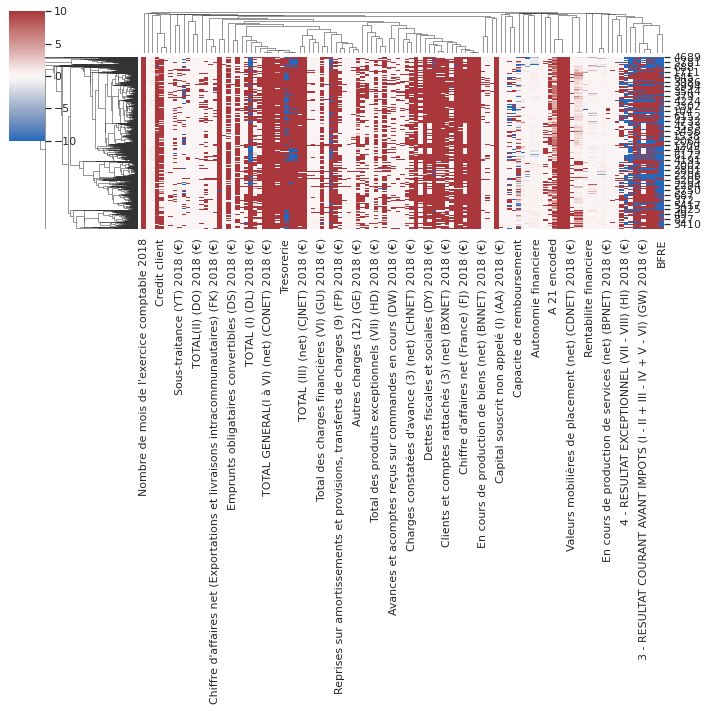

In [100]:
fig = sns.clustermap(df_numeric, metric="correlation", cmap="vlag", vmin=-10, vmax=10)
fig.figsize=(100,100)

In [23]:
corr = df_numeric.corr()

In [26]:
corr = corr.drop(["Taux augmentation endettement CT"], axis=1)

In [28]:
corr=corr.dropna()

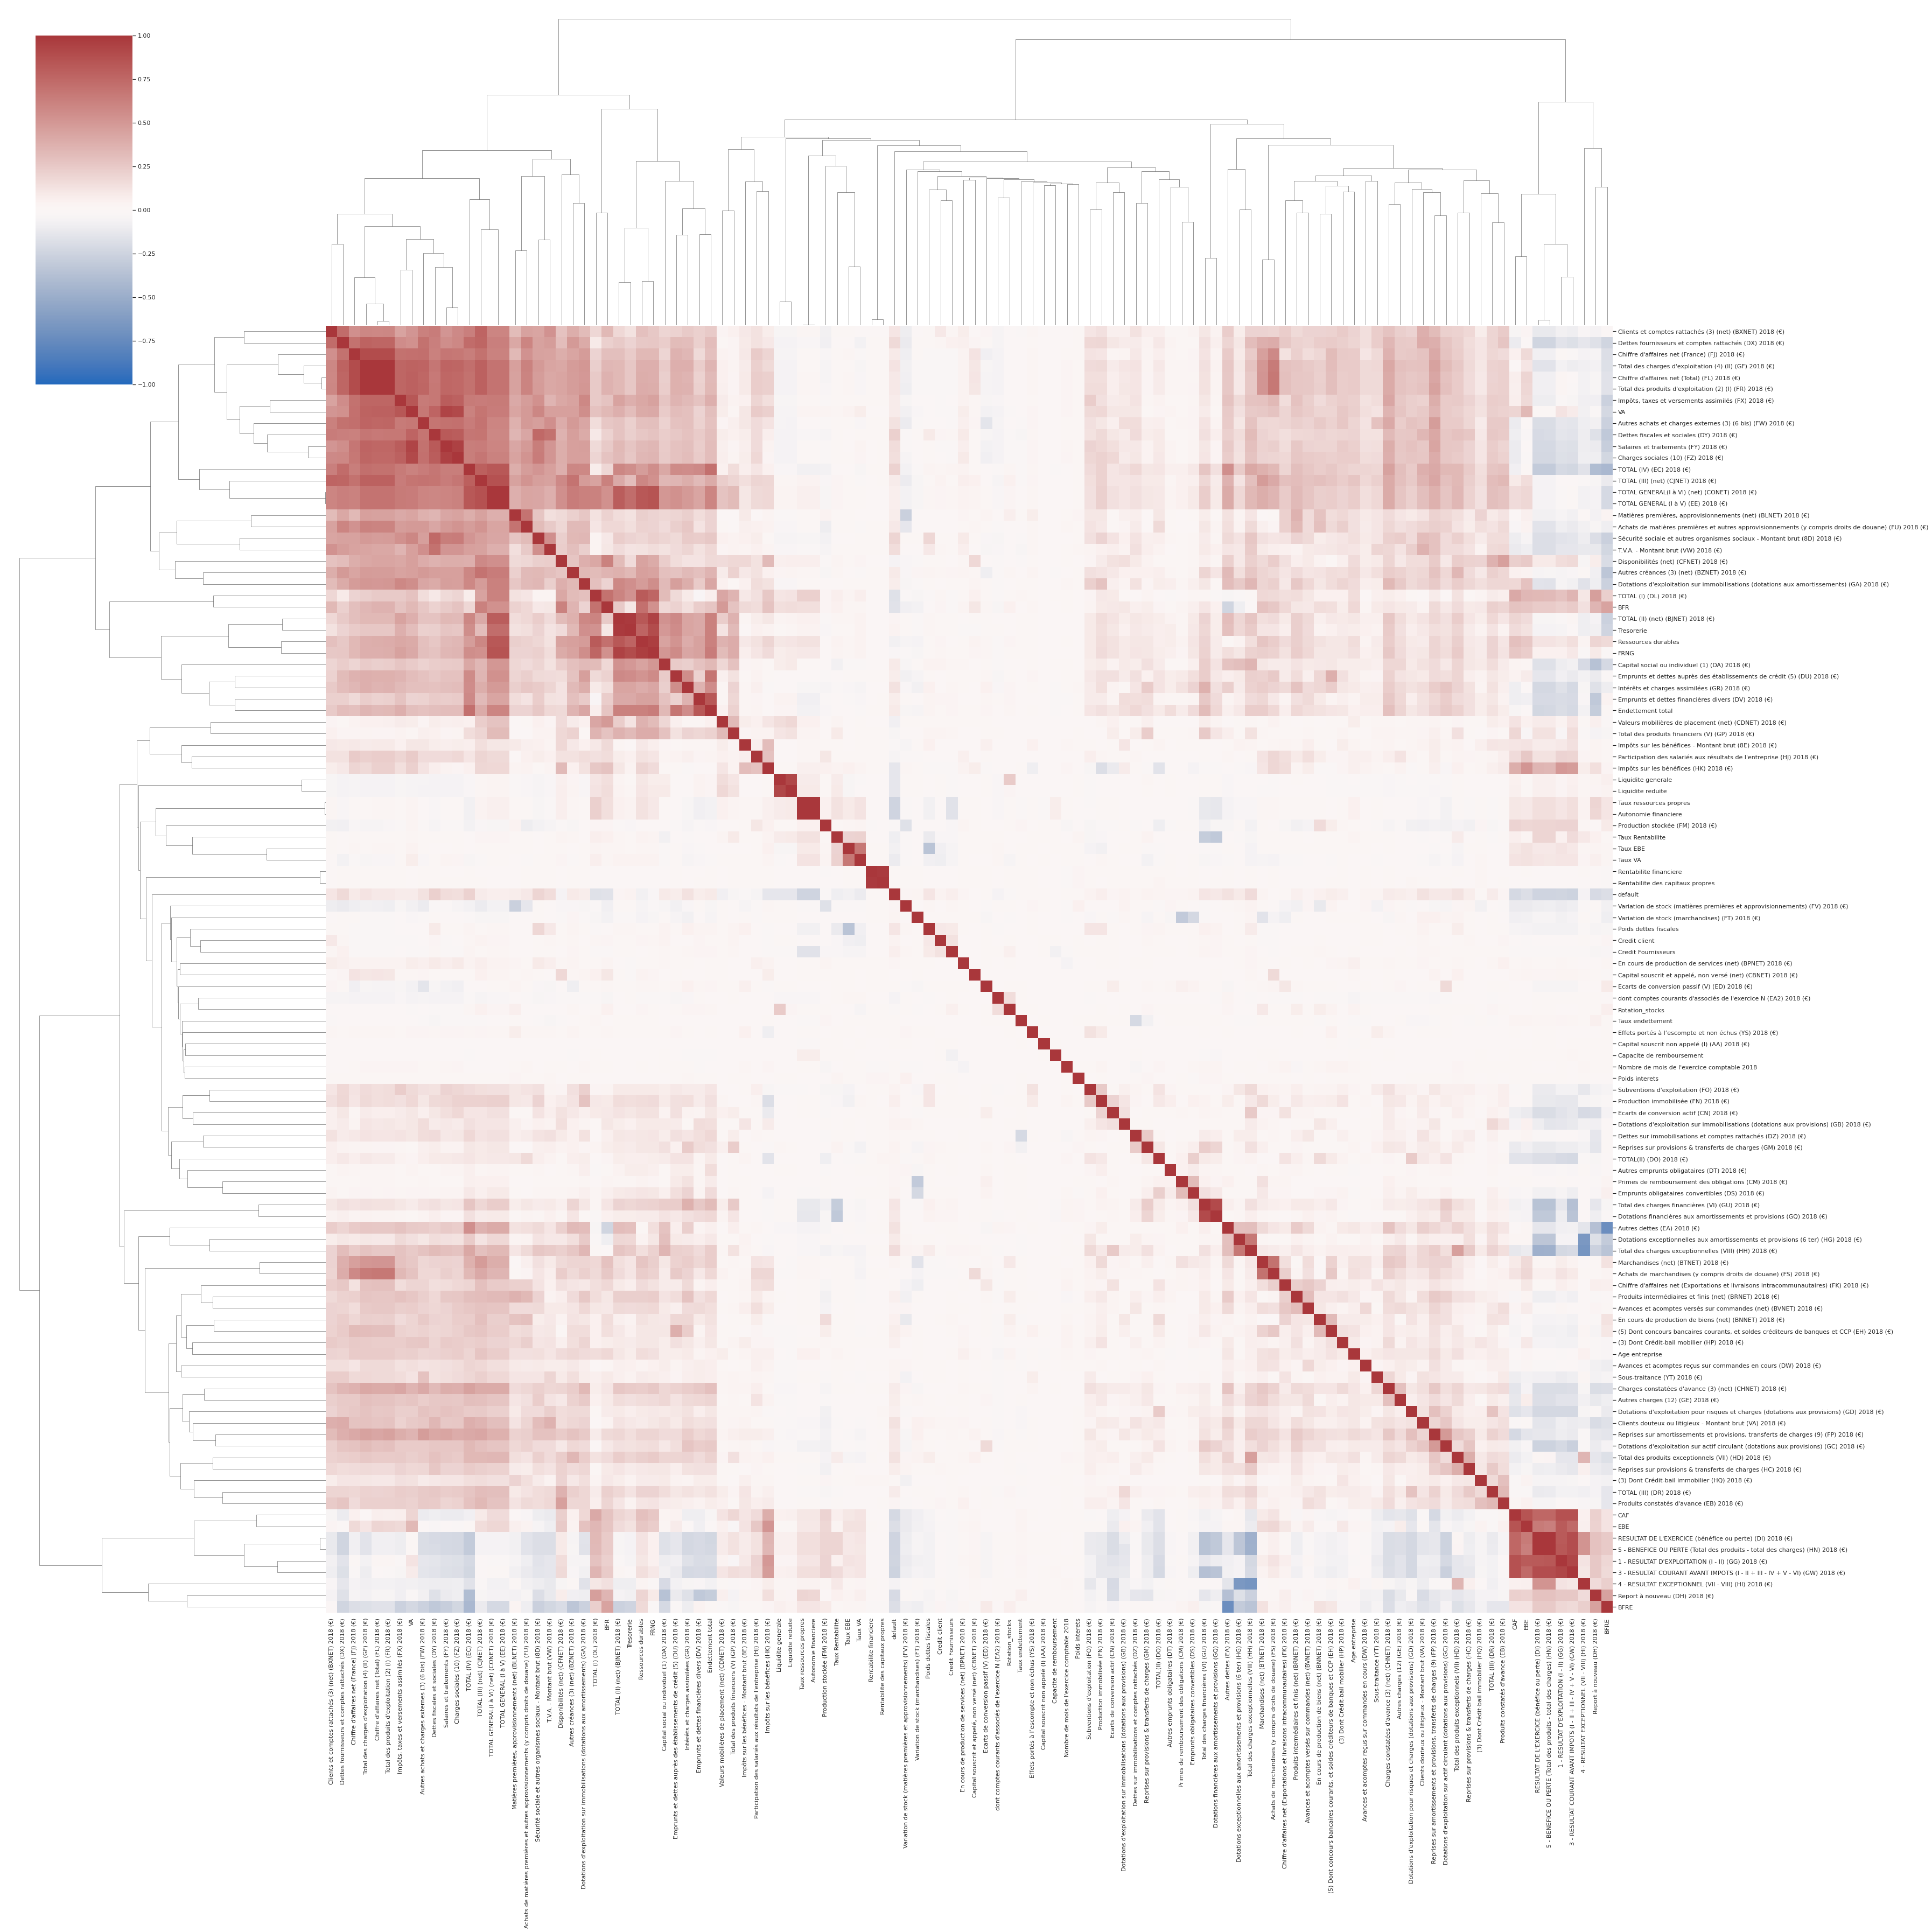

In [32]:
sns.clustermap(corr, figsize=(50,50), annot=False, cmap="vlag", vmin=-1, vmax=1)
plt.savefig("clustermap.png")

# PCA